# Diarrhea Analysis

## Description

This notebook presents a comprehensive analysis and machine learning prediction model based on datasets from five divisions in Bangladesh.

### Objectives

- **Data Exploration**: Conduct an in-depth exploration of the datasets, identifying key features and relationships that characterize each division.
- **Statistical Analysis**: Utilize statistical methods to analyze the data, revealing significant trends and anomalies within the divisions.
- **Machine Learning Models**: Implement various machine learning algorithms to build predictive models that forecast outcomes based on historical data.
- **Comparative Insights**: Compare results across the five divisions to highlight unique characteristics and shared challenges, providing a holistic view of the region.

[link to the dataset](https://github.com/Data-Lab-CU/diarrhea/tree/main/data)

## Data Preprocessing

In this section, we perform several key data manipulation tasks to prepare the dataset for further analysis. This includes cleaning and merging datasets, handling outliers, and transforming variables. We also classify the severity of diarrhea cases based on the count and apply necessary transformations to ensure the data is ready for modeling and analysis.

### Importing all the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

### Loading and Combining Datasets

We are now combining data from all four regions into a single dataframe for easier analysis.

In [ ]:
# Loading the datasets
chattogram = pd.read_csv('https://raw.githubusercontent.com/Data-Lab-CU/diarrhea/main/data/Chattogram.csv')
dhaka = pd.read_csv('https://raw.githubusercontent.com/Data-Lab-CU/diarrhea/main/data/Dhaka.csv')
khulna = pd.read_csv('https://raw.githubusercontent.com/Data-Lab-CU/diarrhea/main/data/Khulna.csv')
rajshahi = pd.read_csv('https://raw.githubusercontent.com/Data-Lab-CU/diarrhea/main/data/Rajshahi.csv')

# Converting 'Date' columns to datetime
rajshahi['Date'] = pd.to_datetime(rajshahi['Date'])
khulna['Date'] = pd.to_datetime(khulna['Date'])
dhaka['Date'] = pd.to_datetime(dhaka['Date'])
chattogram['Date'] = pd.to_datetime(chattogram['Date'])

# Combining all datasets into one
data = pd.concat([rajshahi, khulna, dhaka, chattogram])

# Converting 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Dropping rows with missing values
data.dropna(inplace=True)

### Cleaning Outliers

The following script implements a class `RegionalOutlierHandler` to detect and handle outliers in time-series data for multiple regions.

1. **Initialization**: Specify `window_size` for rolling statistics and `std_threshold` for outlier detection.

2. **Outlier Handling**:
   - For each region, calculate rolling median and standard deviation.
   - Define bounds (`median ± std_threshold * std`) for normal values.
   - Clip values outside the bounds to handle outliers.

3. **Plot Results**:
   - Visualize original vs. cleaned data for each region.
   - Highlight the normal range (confidence intervals) based on rolling statistics.

4. **Usage**: Combine data for multiple regions into a single DataFrame, apply the handler, and visualize the results.

The function `process_all_regions` processes and visualizes data for all specified regions.

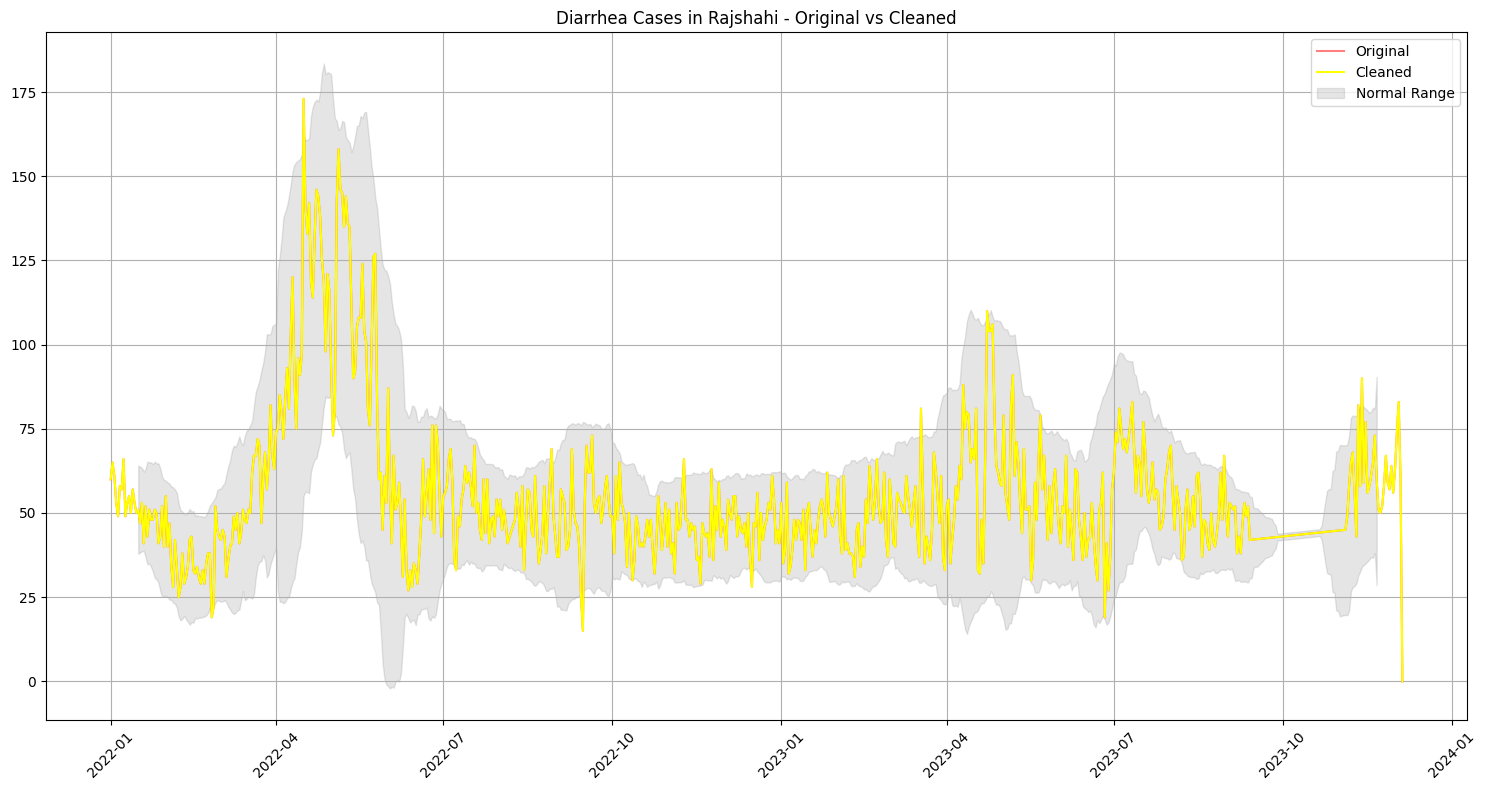

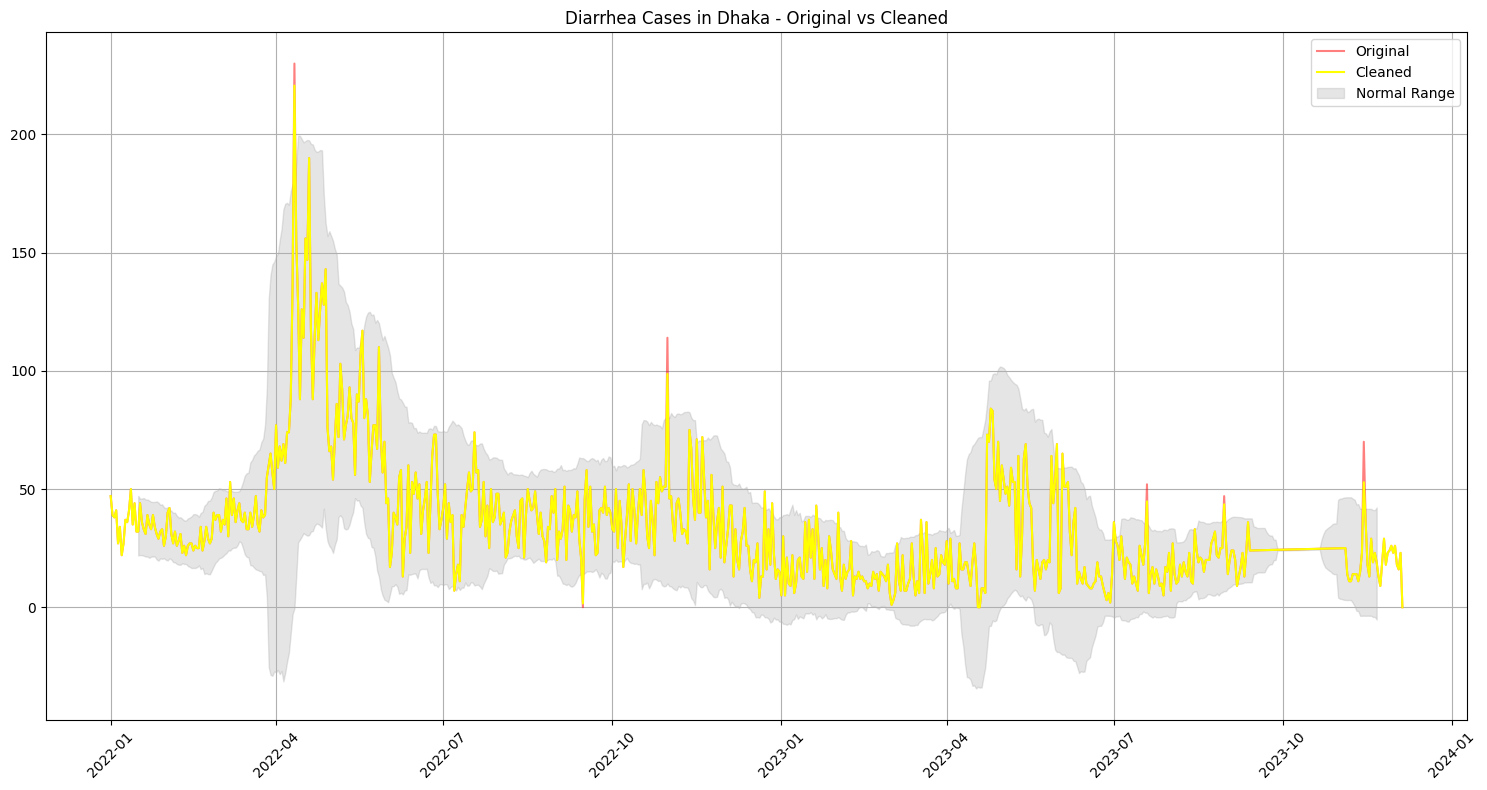

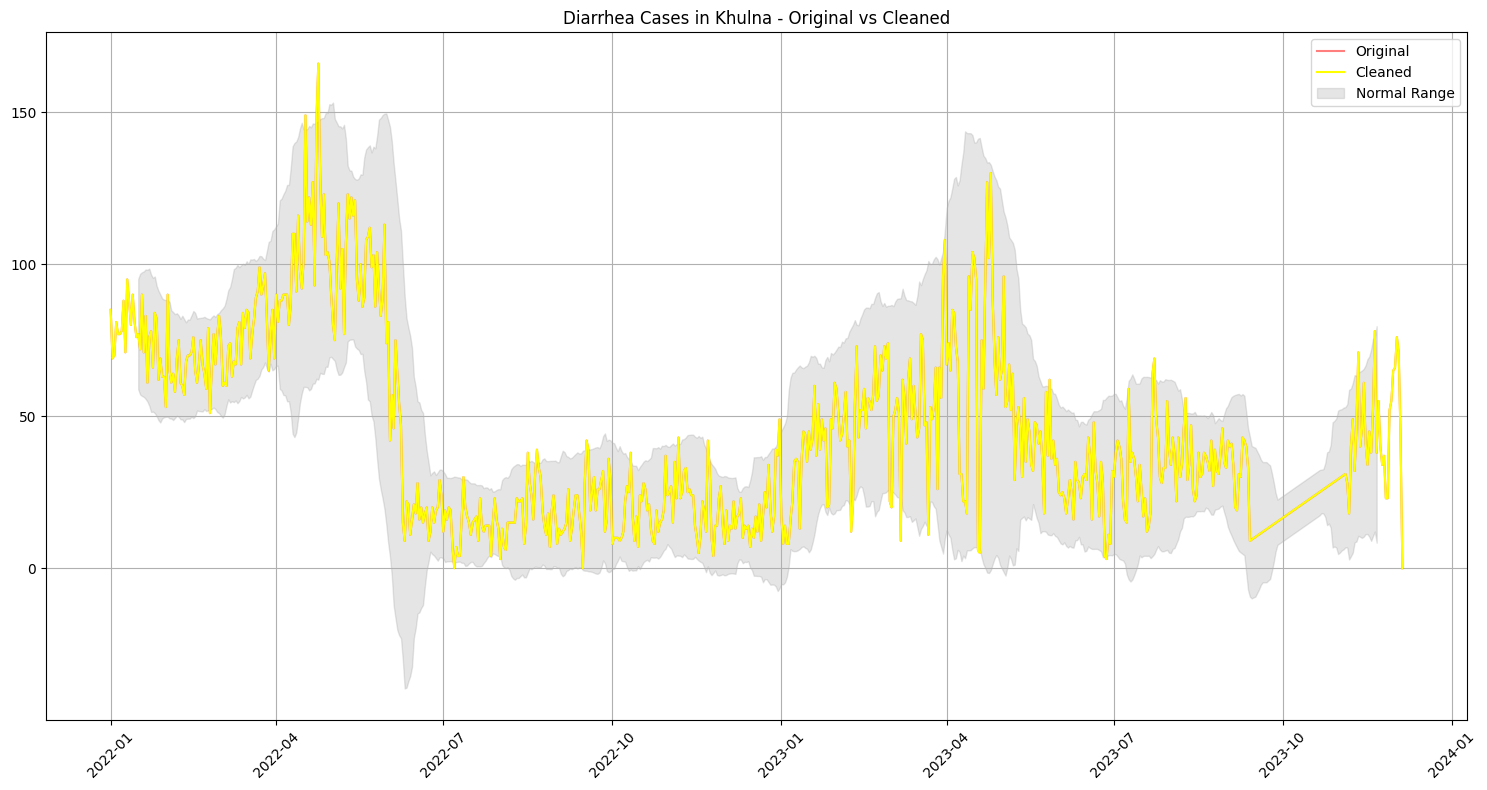

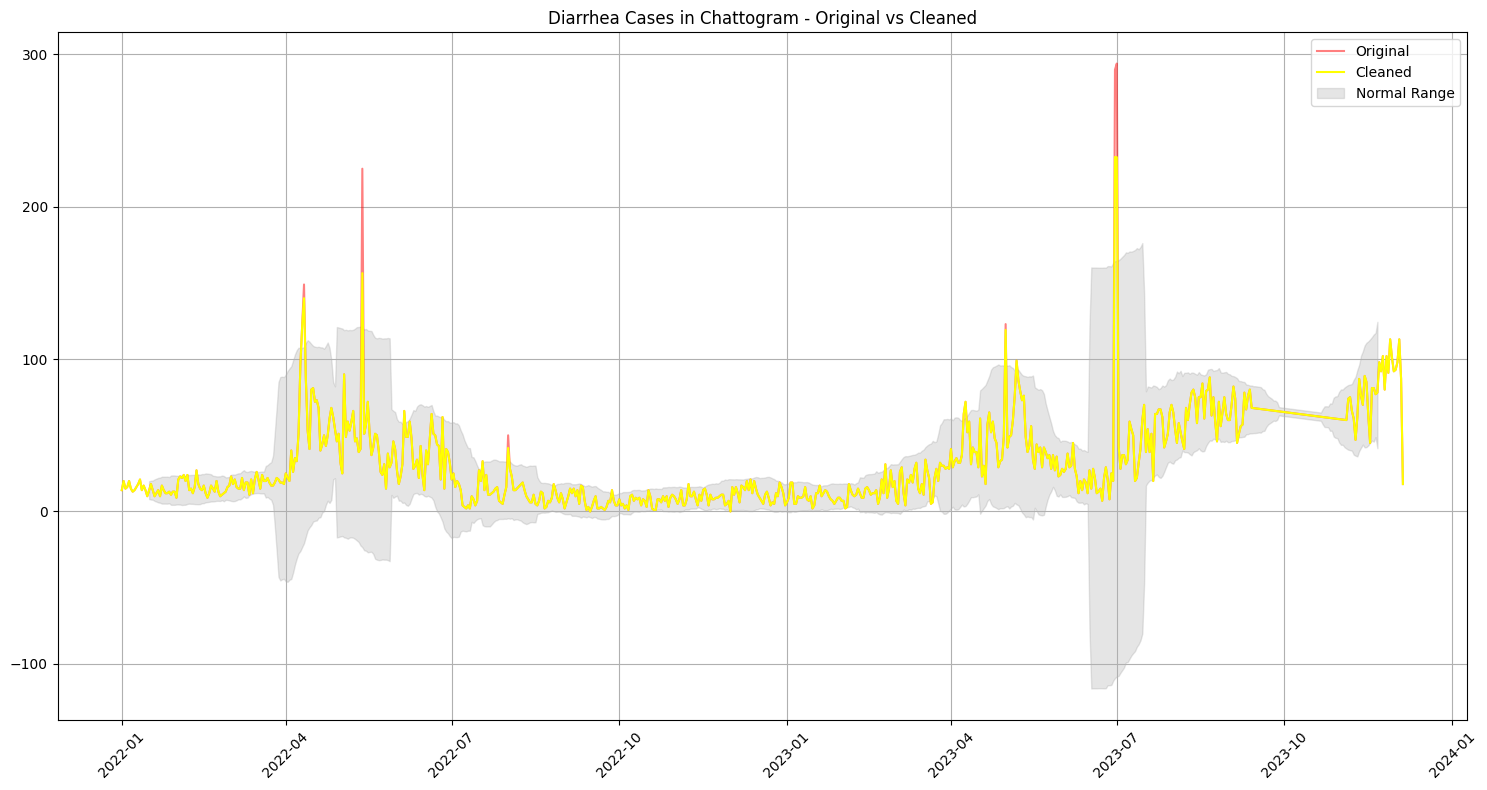

In [ ]:
class RegionalOutlierHandler:
    def __init__(self, window_size=30, std_threshold=3):
        self.window_size = window_size
        self.std_threshold = std_threshold

    def fit_transform(self, df, region_col, date_col, cases_col):
        """
        Handles outliers for each region without seasonal decomposition.
        """
        df_cleaned = df.copy()
        df_cleaned['cleaned_cases'] = df_cleaned[cases_col].copy()

        # Process each region separately
        for region in df_cleaned[region_col].unique():
            mask = df_cleaned[region_col] == region
            region_data = df_cleaned[mask].copy()

            # 1. Calculate dynamic thresholds
            rolling_med = region_data[cases_col].rolling(
                window=self.window_size, center=True
            ).median()

            rolling_std = region_data[cases_col].rolling(
                window=self.window_size, center=True
            ).std()

            # 2. Define bounds
            upper_bound = rolling_med + (self.std_threshold * rolling_std)
            lower_bound = rolling_med - (self.std_threshold * rolling_std)

            # 3. Handle outliers by clipping values to the bounds
            cleaned_values = region_data[cases_col].clip(
                lower=lower_bound,
                upper=upper_bound
            )

            # 4. Update the cleaned values
            df_cleaned.loc[mask, 'cleaned_cases'] = cleaned_values

        return df_cleaned

    def plot_results(self, df, region, original_col, cleaned_col, date_col):
        """Plot original vs cleaned data for a specific region."""
        region_data = df[df['Region'] == region]

        plt.figure(figsize=(15, 8))
        plt.plot(region_data[date_col], region_data[original_col],
                 label='Original', color='red', alpha=0.5)
        plt.plot(region_data[date_col], region_data[cleaned_col],
                 label='Cleaned', color='yellow')

        # Add confidence intervals
        rolling_med = region_data[original_col].rolling(
            window=self.window_size, center=True
        ).median()
        rolling_std = region_data[original_col].rolling(
            window=self.window_size, center=True
        ).std()

        plt.fill_between(
            region_data[date_col],
            rolling_med - (2 * rolling_std),
            rolling_med + (2 * rolling_std),
            alpha=0.2, color='gray', label='Normal Range'
        )

        plt.title(f'Diarrhea Cases in {region} - Original vs Cleaned')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage:
def process_all_regions(data_dict):
    """
    Apply outlier handling for multiple regions.
    """
    combined_df = pd.DataFrame()
    for region, df in data_dict.items():
        temp_df = df.copy()
        temp_df['Region'] = region
        combined_df = pd.concat([combined_df, temp_df])

    # Initialize and apply the outlier handler
    handler = RegionalOutlierHandler(window_size=30, std_threshold=3)
    cleaned_df = handler.fit_transform(
        combined_df,
        region_col='Region',
        date_col='Date',
        cases_col='Diarrhea'
    )

    for region in data_dict.keys():
        handler.plot_results(
            cleaned_df,
            region=region,
            original_col='Diarrhea',
            cleaned_col='cleaned_cases',
            date_col='Date'
        )

    return cleaned_df

# Assuming you have your data in DataFrames
data_dict = {
    'Rajshahi': rajshahi,
    'Dhaka': dhaka,
    'Khulna': khulna,
    'Chattogram': chattogram
}

cleaned_data = process_all_regions(data_dict)


In [ ]:
rajshahi_cleaned = cleaned_data[cleaned_data['Region'] == 'Rajshahi']
khulna_cleaned = cleaned_data[cleaned_data['Region'] == 'Khulna']
dhaka_cleaned = cleaned_data[cleaned_data['Region'] == 'Dhaka']
chattogram_cleaned = cleaned_data[cleaned_data['Region'] == 'Chattogram']

## Exploratory Data Analysis


> Let's start by addressing some key questions:

  1. What is the trend of diarrhea cases over time in each division?
  
  2. How do temperature, humidity, and precipitation correlate with diarrhea cases?
  3. Are there any significant differences in diarrhea cases among the four divisions?

### Primary Line Plot

**Monthly Diarrhea Rates by Region**

The line plot visualizes the trend of diarrhea cases across four major regions of Bangladesh: Chattogram, Dhaka, Khulna, and Rajshahi. The plot highlights the fluctuations in diarrhea rates over time, offering a clear comparison between regions.

In [ ]:
fig = px.line(rajshahi_cleaned, x='Date', y='cleaned_cases', title='Cleaned Diarrhea Cases in Rajshahi', labels={'cleaned_cases': 'Cleaned Cases'})
fig.show()
fig = px.line(khulna_cleaned, x='Date', y='cleaned_cases', title='Cleaned Diarrhea Cases in Khulna', labels={'cleaned_cases': 'Cleaned Cases'})
fig.show()
fig = px.line(dhaka_cleaned, x='Date', y='cleaned_cases', title='Cleaned Diarrhea Cases in Dhaka', labels={'cleaned_cases': 'Cleaned Cases'})
fig.show()
fig = px.line(chattogram_cleaned, x='Date', y='cleaned_cases', title='Cleaned Diarrhea Cases in Chattogram', labels={'cleaned_cases': 'Cleaned Cases'})
fig.show()


**Regional Diarrhea Rates Comparison**

In [ ]:
handler = RegionalOutlierHandler(window_size=30, std_threshold=3)

# Create the 'Region' column for each DataFrame BEFORE applying fit_transform
rajshahi['Region'] = 'Rajshahi'
khulna['Region'] = 'Khulna'
dhaka['Region'] = 'Dhaka'
chattogram['Region'] = 'Chattogram'

# Apply outlier handling to each division, using the correct region column
rajshahi_cleaned = handler.fit_transform(rajshahi, region_col='Region', date_col='Date', cases_col='Diarrhea')
khulna_cleaned = handler.fit_transform(khulna, region_col='Region', date_col='Date', cases_col='Diarrhea')
dhaka_cleaned = handler.fit_transform(dhaka, region_col='Region', date_col='Date', cases_col='Diarrhea')
chattogram_cleaned = handler.fit_transform(chattogram, region_col='Region', date_col='Date', cases_col='Diarrhea')

# Create the 'Division' column for each cleaned DataFrame (if you still need this for plotting)
rajshahi_cleaned['Division'] = 'Rajshahi'
khulna_cleaned['Division'] = 'Khulna'
dhaka_cleaned['Division'] = 'Dhaka'
chattogram_cleaned['Division'] = 'Chattogram'

# Concatenate the cleaned DataFrames
combined_df_cleaned = pd.concat([rajshahi_cleaned, khulna_cleaned, dhaka_cleaned, chattogram_cleaned])
# Plot using the combined DataFrame and the 'Division' column for color, using cleaned cases
fig = px.line(combined_df_cleaned,
              x='Date',
              y='cleaned_cases',  # Using cleaned_cases instead of Diarrhea
              color='Division',
              title='Cleaned Diarrhea Cases in Different Divisions',
              labels={'cleaned_cases': 'Cleaned Cases', 'Division': 'Division'})
fig.show()

> The trend plots for diarrhea cases over time in the four divisions (Rajshahi, Khulna, Dhaka, and Chattogram) reveal the following:

1. **Rajshahi:** Diarrhea cases show fluctuations over time with noticeable peaks and dips.

2. **Khulna:** Similar to Rajshahi, Khulna also exhibits fluctuations in diarrhea cases, with some periods showing higher cases.

3. **Dhaka:** The trend in Dhaka shows a more consistent pattern with fewer extreme peaks compared to Rajshahi and Khulna.

4. **Chattogram:** Chattogram displays a relatively stable trend with minor fluctuations in diarrhea cases.

Overall, each division shows variability in diarrhea cases over time, with some divisions experiencing more pronounced peaks and troughs than others.

### Visualizing Correlation Matrix

To understand the relationships between the numerical variables in our dataset,
> We will create a correlation matrix. This matrix helps identify which features are strongly or weakly correlated, providing insights into how the variables interact with each other.

> The heatmap visualization makes it easier to interpret these correlations visually, using a color scale to highlight the strength of the relationships.



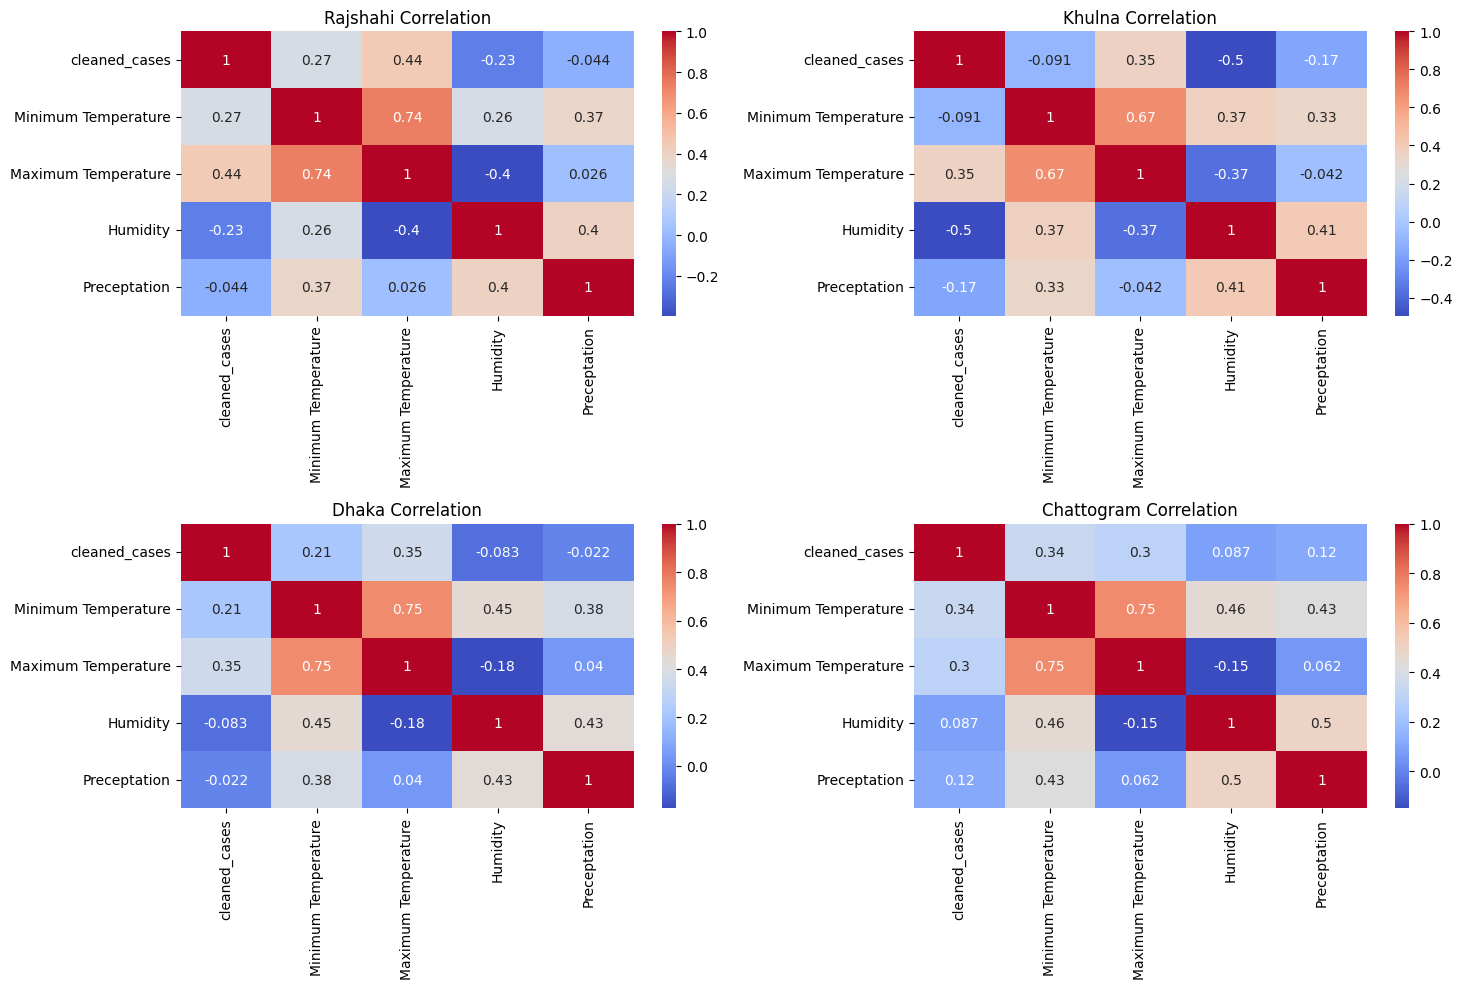

In [ ]:
# Calculate correlations with cleaned cases
rajshahi_corr = rajshahi_cleaned[['cleaned_cases', 'Minimum Temperature', 'Maximum Temperature', 'Humidity', 'Preceptation']].dropna().corr()
khulna_corr = khulna_cleaned[['cleaned_cases', 'Minimum Temperature', 'Maximum Temperature', 'Humidity', 'Preceptation']].dropna().corr()
dhaka_corr = dhaka_cleaned[['cleaned_cases', 'Minimum Temperature', 'Maximum Temperature', 'Humidity', 'Preceptation']].dropna().corr()
chattogram_corr = chattogram_cleaned[['cleaned_cases', 'Minimum Temperature', 'Maximum Temperature', 'Humidity', 'Preceptation']].dropna().corr()

# Plotting heatmaps
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.heatmap(rajshahi_corr, annot=True, cmap='coolwarm', ax=axes[0, 0]).set_title('Rajshahi Correlation')
sns.heatmap(khulna_corr, annot=True, cmap='coolwarm', ax=axes[0, 1]).set_title('Khulna Correlation')
sns.heatmap(dhaka_corr, annot=True, cmap='coolwarm', ax=axes[1, 0]).set_title('Dhaka Correlation')
sns.heatmap(chattogram_corr, annot=True, cmap='coolwarm', ax=axes[1, 1]).set_title('Chattogram Correlation')
plt.tight_layout()
plt.show()

> The correlation heatmaps for each division reveal the following:

1. **Rajshahi:** Diarrhea cases have a moderate positive correlation with minimum temperature and a weak positive correlation with maximum temperature. Humidity and precipitation show weak correlations with diarrhea cases.

2. **Khulna:** Diarrhea cases have a moderate positive correlation with minimum temperature and a weak positive correlation with maximum temperature. Humidity and precipitation show weak correlations with diarrhea cases.

3. **Dhaka:** Diarrhea cases have a moderate positive correlation with minimum temperature and a weak positive correlation with maximum temperature. Humidity and precipitation show weak correlations with diarrhea cases.

4. **Chattogram:** Diarrhea cases have a moderate positive correlation with minimum temperature and a weak positive correlation with maximum temperature. Humidity and precipitation show weak correlations with diarrhea cases.

Overall, minimum temperature appears to have the strongest correlation with diarrhea cases across all divisions, while other weather variables show weaker correlations.

### Time Series Analysis

> We will perform a **time series analysis** to identify any seasonal patterns or trends in diarrhea cases for each division.

> We'll use decomposition to separate the time series into trend, seasonal, and residual components.

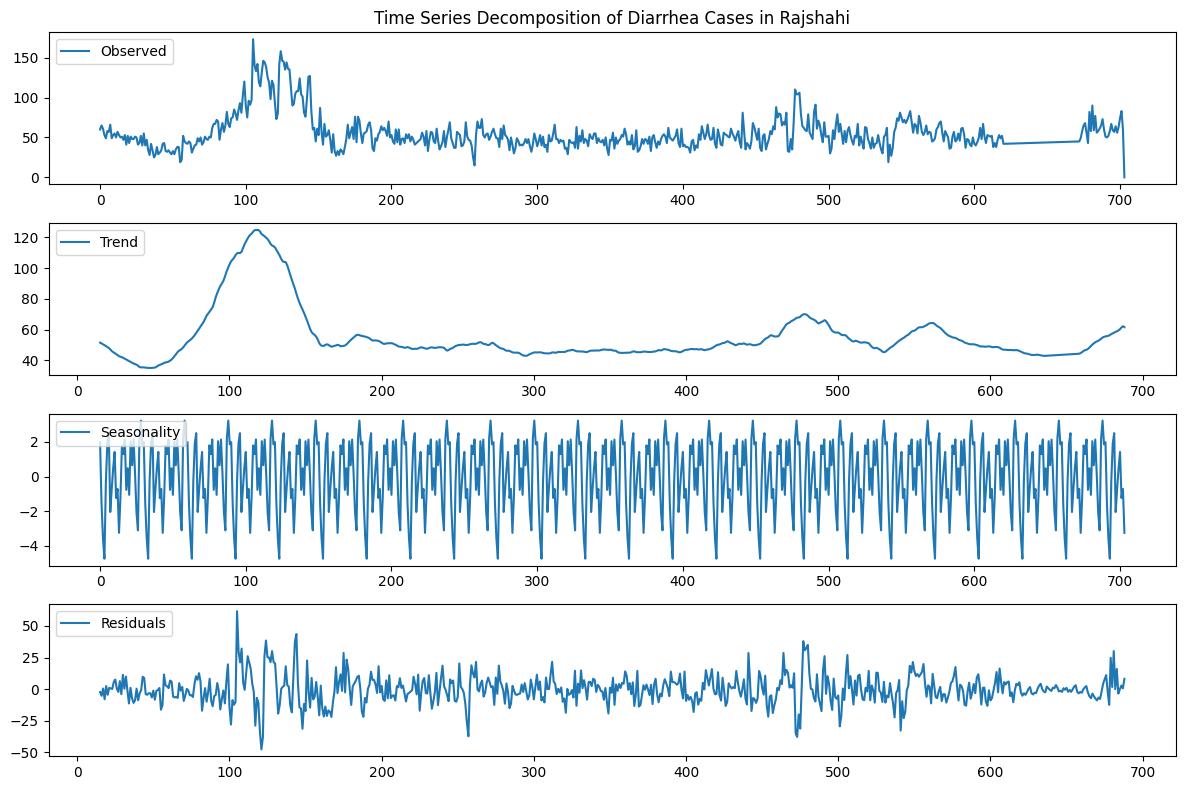

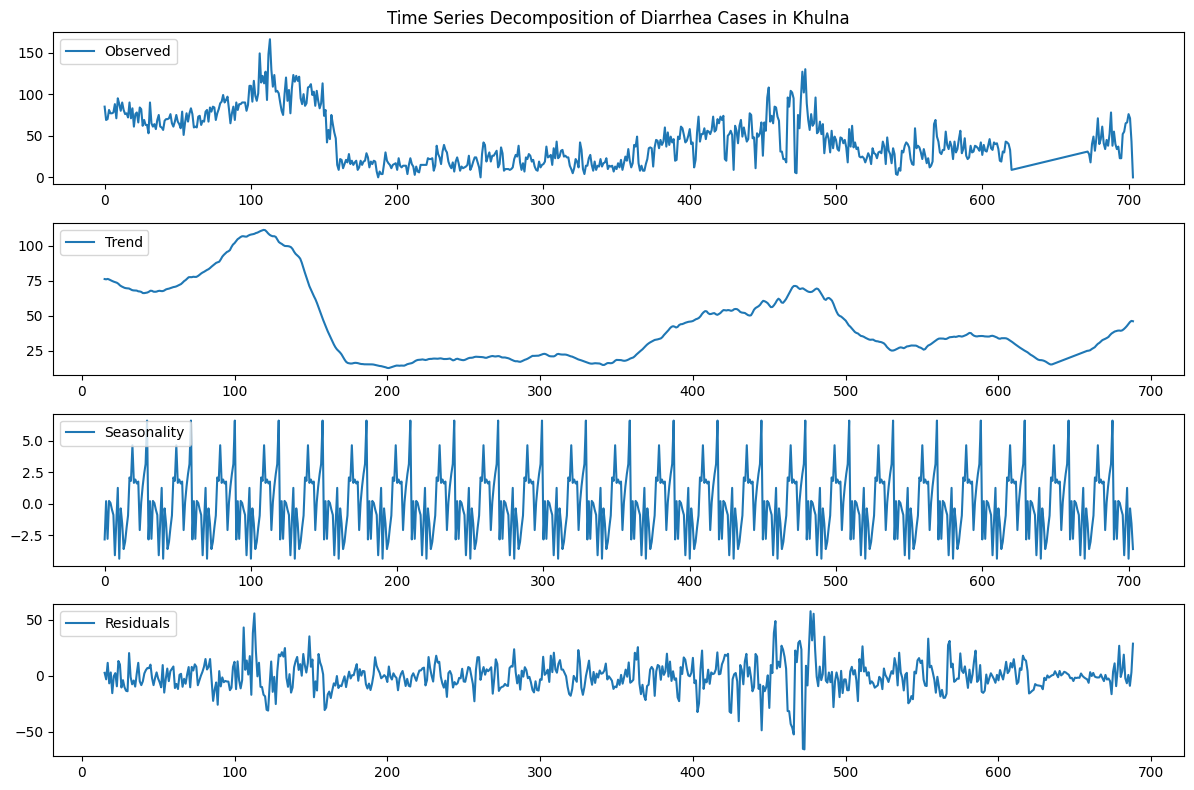

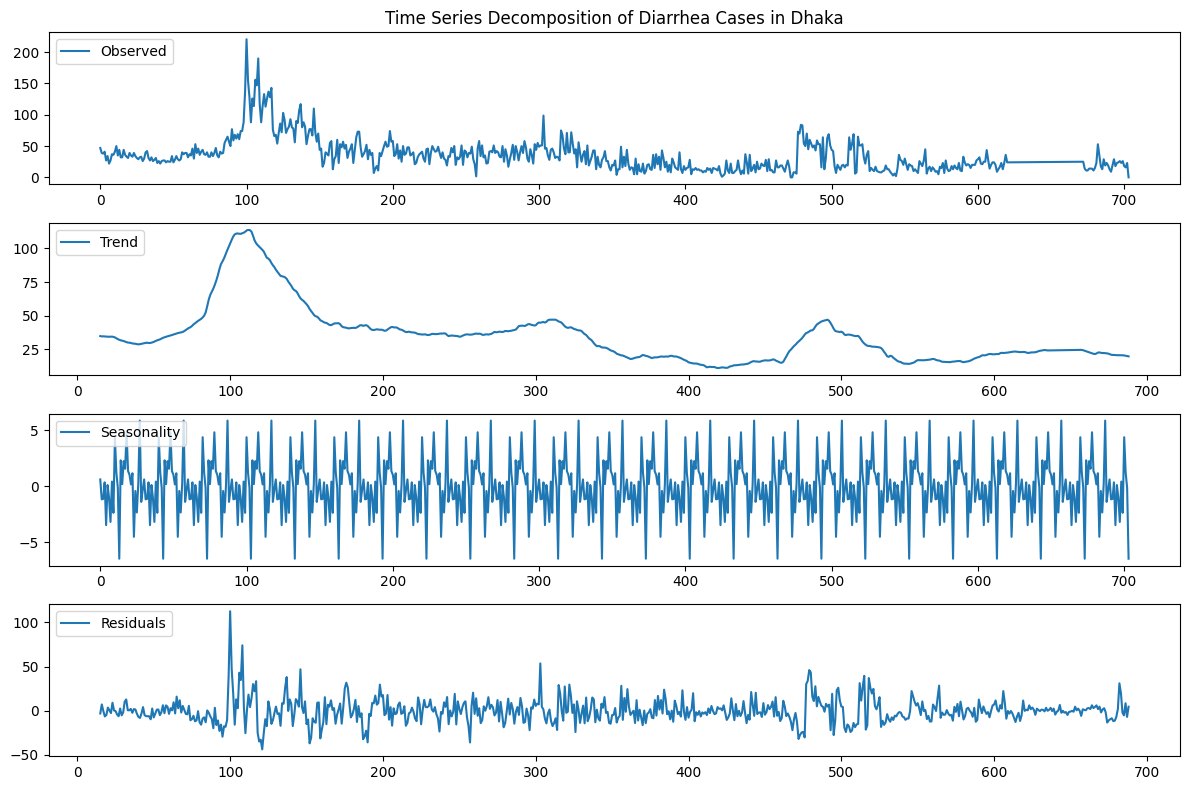

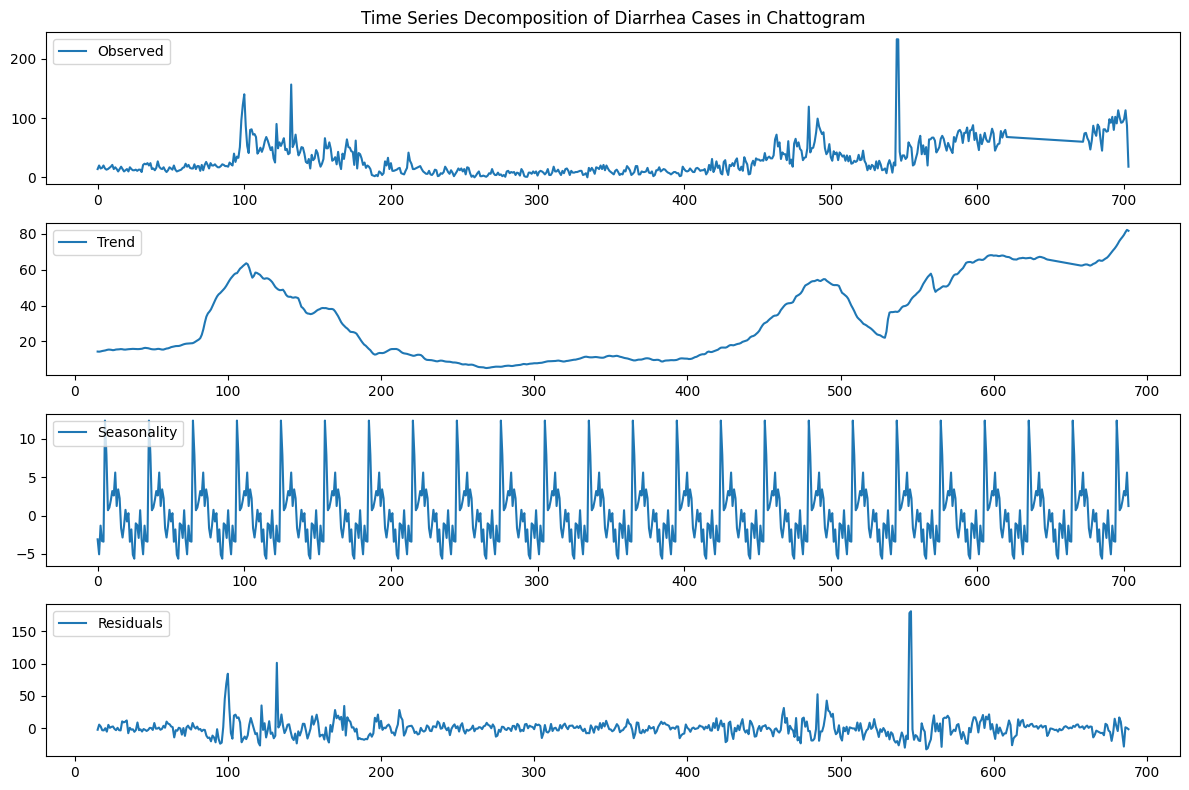

In [ ]:
# Function to perform decomposition and plot using cleaned data
def decompose_and_plot(df, division_name):
    decomposition = seasonal_decompose(df['cleaned_cases'], model='additive', period=30)  # Use 'cleaned_cases' here

    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed')
    plt.legend(loc='upper left')
    plt.title(f'Time Series Decomposition of Diarrhea Cases in {division_name}')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='upper left')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality')
    plt.legend(loc='upper left')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Performing decomposition and plot for each division using cleaned data
decompose_and_plot(rajshahi_cleaned, 'Rajshahi')
decompose_and_plot(khulna_cleaned, 'Khulna')
decompose_and_plot(dhaka_cleaned, 'Dhaka')
decompose_and_plot(chattogram_cleaned, 'Chattogram')


> The time series decomposition of diarrhea cases for each division reveals the following:

1. **Rajshahi:** The decomposition shows a clear seasonal pattern with periodic peaks and troughs, along with a noticeable trend component.

2. **Khulna:** Similar to Rajshahi, Khulna exhibits a seasonal pattern and a trend component, indicating periodic fluctuations in diarrhea cases.

3. **Dhaka:** The seasonal pattern in Dhaka is less pronounced compared to Rajshahi and Khulna, but a trend component is still evident.

4. **Chattogram:** Chattogram shows a relatively stable seasonal pattern with minor fluctuations and a clear trend component.

Overall, all divisions exhibit some degree of seasonality and trend in diarrhea cases, with Rajshahi and Khulna showing more pronounced seasonal patterns.

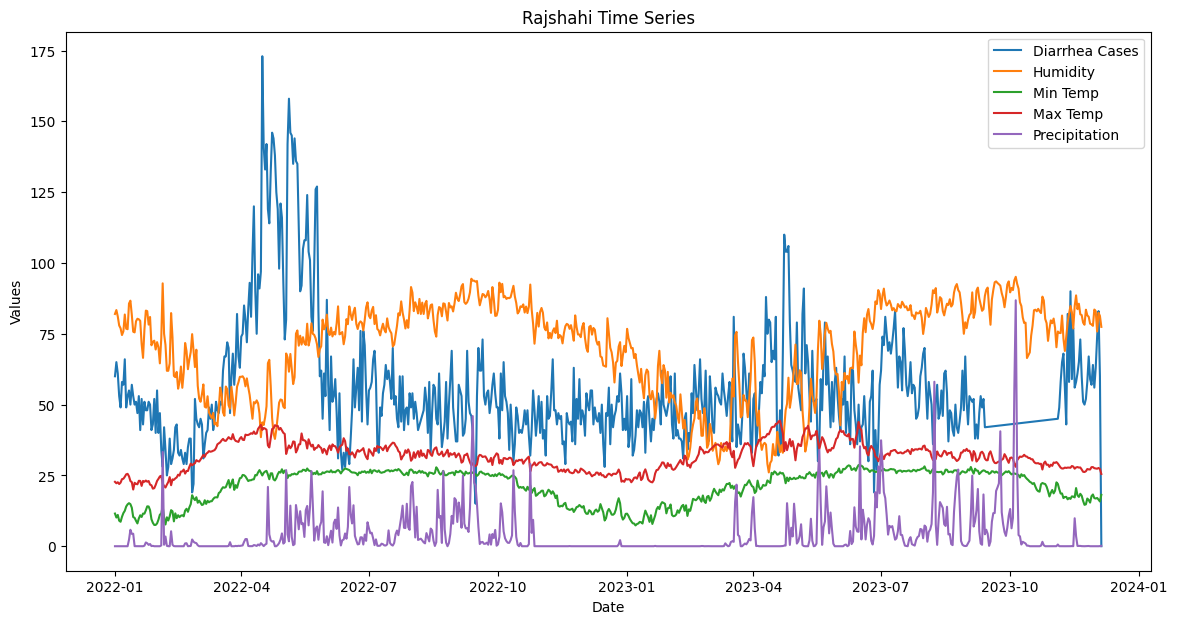

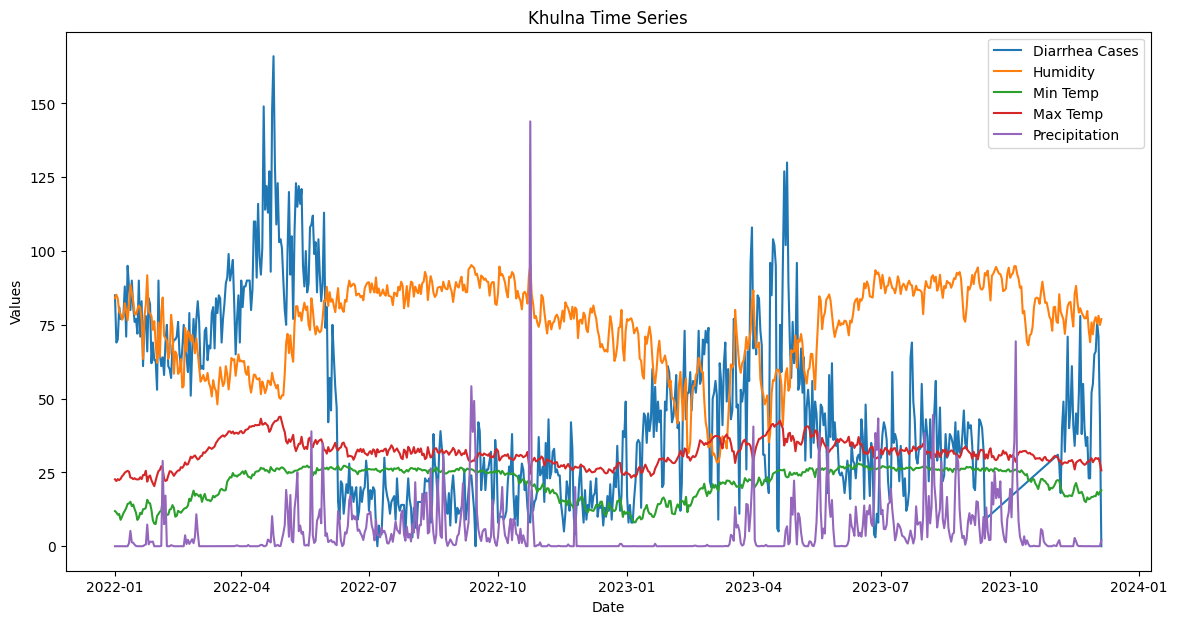

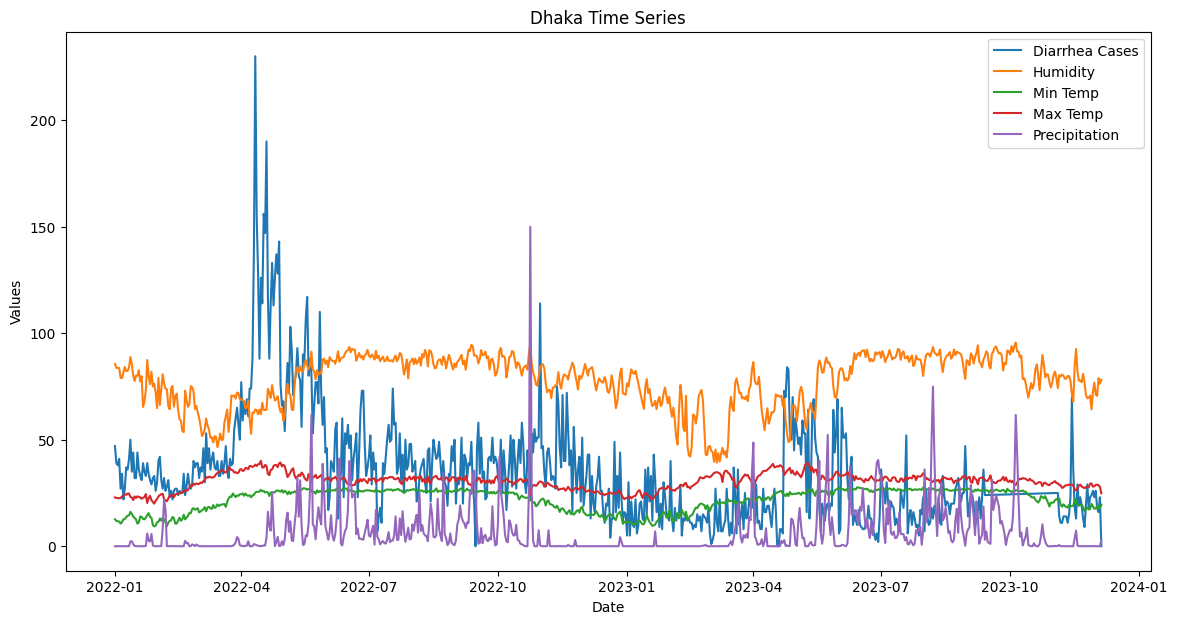

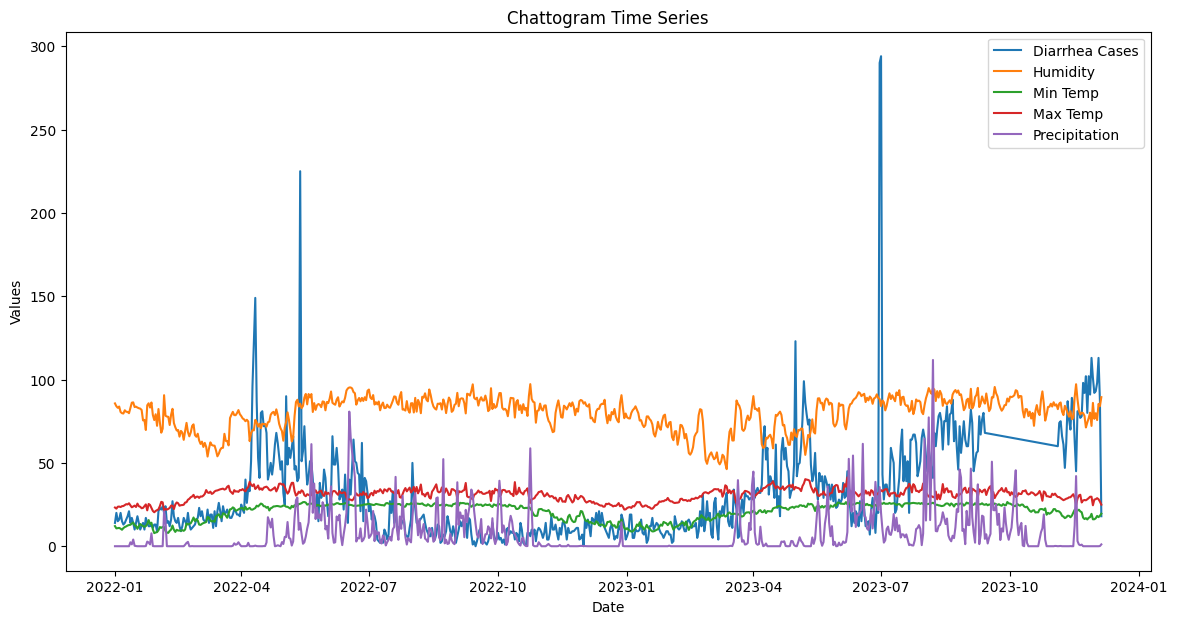

In [ ]:
# Ploting time series for each division
def plot_time_series(df, title):
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Diarrhea'], label='Diarrhea Cases')
    plt.plot(df['Date'], df['Humidity'], label='Humidity')
    plt.plot(df['Date'], df['Minimum Temperature'], label='Min Temp')
    plt.plot(df['Date'], df['Maximum Temperature'], label='Max Temp')
    plt.plot(df['Date'], df['Preceptation'], label='Precipitation')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.show()

plot_time_series(rajshahi_cleaned, 'Rajshahi Time Series')
plot_time_series(khulna_cleaned, 'Khulna Time Series')
plot_time_series(dhaka_cleaned, 'Dhaka Time Series')
plot_time_series(chattogram_cleaned, 'Chattogram Time Series')

> The time series plots for each division show the following trends:

1. **Rajshahi:** Diarrhea cases fluctuate over time, with noticeable peaks. Humidity and minimum temperature also show seasonal variations, while precipitation has sporadic spikes.

2. **Khulna:** Diarrhea cases exhibit periodic peaks. Humidity and minimum temperature display seasonal patterns, and precipitation shows occasional high values.

3. **Dhaka:** Diarrhea cases have periodic peaks. Humidity and minimum temperature follow seasonal trends, and precipitation has irregular spikes.

4. **Chattogram:** Diarrhea cases show periodic peaks. Humidity and minimum temperature vary seasonally, and precipitation has sporadic high values.

Overall, diarrhea cases appear to have a seasonal pattern, potentially influenced by humidity and temperature variations.

## Model Prediction

> We will perform various algorithms to predict diarrhea cases based on four environmental factors: Maximum Temperature, Minimum Temparature, Humidity, and Precipitation.

> For each of these factors, the code fits a linear model and visualizes the relationship with diarrhea rates using scatter plots and regression lines.

> The scatter plot displays the actual data points, while the regression line illustrates the predicted trend. The plots help in understanding how these environmental factors might influence the occurrence of diarrhea.

In [ ]:
# Define features (X) and target (y)
X = cleaned_data[['Minimum Temperature', 'Maximum Temperature', 'Humidity', 'Preceptation']]
y = cleaned_data['cleaned_cases']

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test

Minimum Temperature  Maximum Temperature  Humidity  Preceptation
450                21.58                35.98     51.50          0.66
470                24.40                37.01     63.75          0.00
488                24.84                33.30     72.50         17.97
314                17.14                29.18     79.94          0.00
236                24.60                32.33     87.12          2.24
..                   ...                  ...       ...           ...
346                15.06                26.62     67.38          0.00
261                24.96                32.59     89.38         16.31
185                24.83                33.33     85.00          3.06
601                24.76                30.08     93.44         20.63
337                11.51                25.46     72.50          0.00

[564 rows x 4 columns]

In [ ]:
def plot_actual_vs_predicted(y_test, y_pred, model_name):

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"--- {model_name} ---")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test, color='red', label='Actual', alpha=0.7) #Actual values in red
    plt.scatter(y_test, y_pred, color='teal', label='Predicted', alpha=0.7) # Predicted in green
    plt.xlabel("Actual Diarrhea Cases")
    plt.ylabel("Predicted Diarrhea Cases")
    plt.title(f"Actual vs. Predicted Diarrhea Cases ({model_name})")
    plt.legend()
    plt.show()

### Linear Regression

--- Linear Regression ---
Mean Squared Error: 595.1340353451553
R-squared: 0.15323894594320087


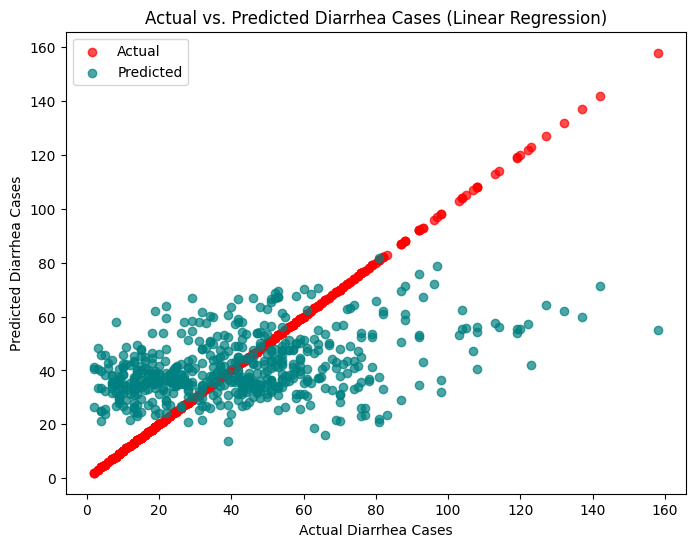

In [ ]:
# (Your existing code for Linear Regression)
dt_model = LinearRegression()
dt_model.fit(X_train, y_train)
dt_y_pred = dt_model.predict(X_test)
plot_actual_vs_predicted(y_test, dt_y_pred, "Linear Regression")

### Random Forest

--- Random Forest ---
Mean Squared Error: 575.8505352563644
R-squared: 0.1806756507715831


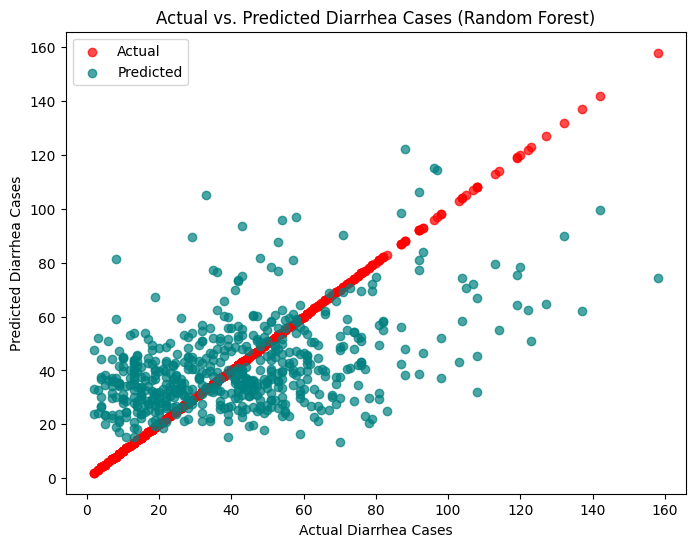

In [ ]:
# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
plot_actual_vs_predicted(y_test, rf_y_pred, "Random Forest")

### Support Vector Regression (SVR)

--- SVR ---
Mean Squared Error: 606.6644985586742
R-squared: 0.13683331863139725


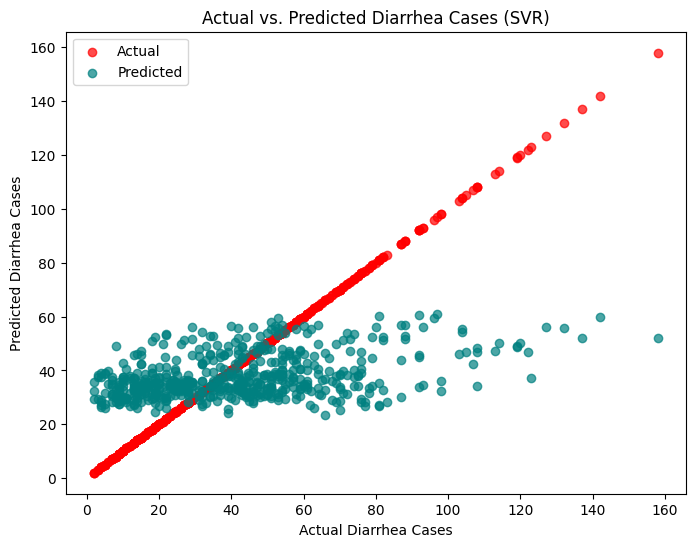

In [ ]:
# Support Vector Regression (SVR)
svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_y_pred = svr_model.predict(X_test)
plot_actual_vs_predicted(y_test, svr_y_pred, "SVR")

### Decision Tree

--- Decision Tree ---
Mean Squared Error: 981.4401268844872
R-squared: -0.39640018378779507


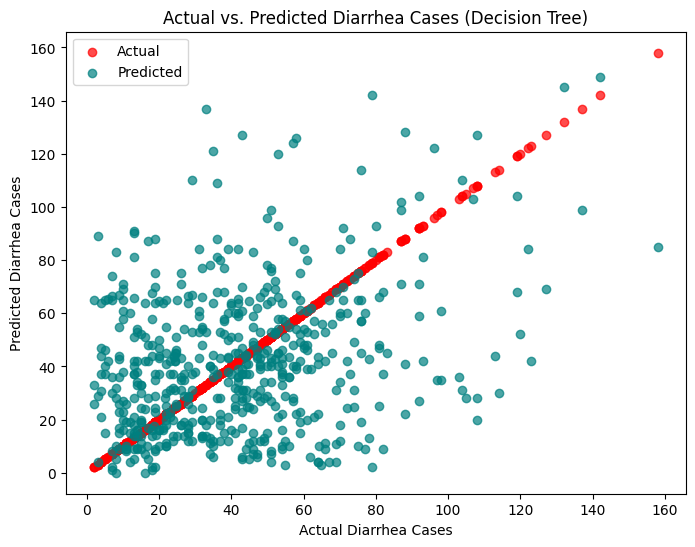

In [ ]:
# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_y_pred = dt_model.predict(X_test)
plot_actual_vs_predicted(y_test, dt_y_pred, "Decision Tree")

### RFGBT

--- Random Forest with Gradient Boosting ---
Mean Squared Error: 519.4653913779804
R-squared: 0.2609008454807289


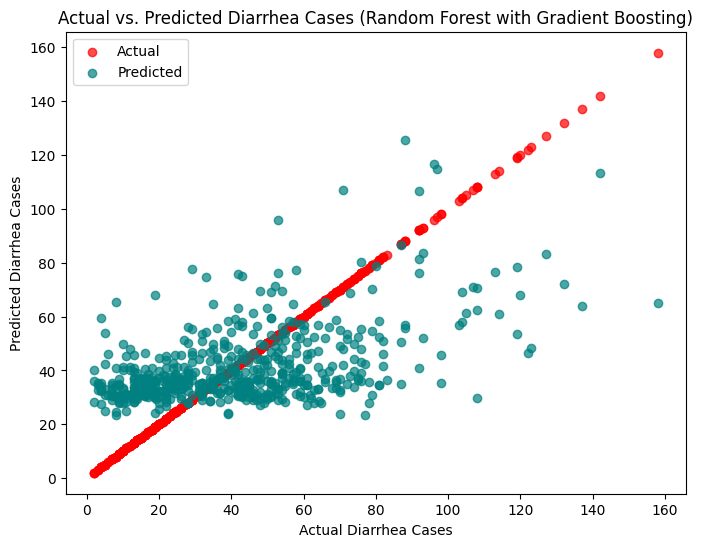

In [ ]:
rfgbt_model = GradientBoostingRegressor(random_state=42)
rfgbt_model.fit(X_train, y_train)
rfgbt_y_pred = rfgbt_model.predict(X_test)
plot_actual_vs_predicted(y_test, rfgbt_y_pred, "Random Forest with Gradient Boosting")

### RFXBT

--- Gradient Boosting ---
Mean Squared Error: 519.4653913779804
R-squared: 0.2609008454807289


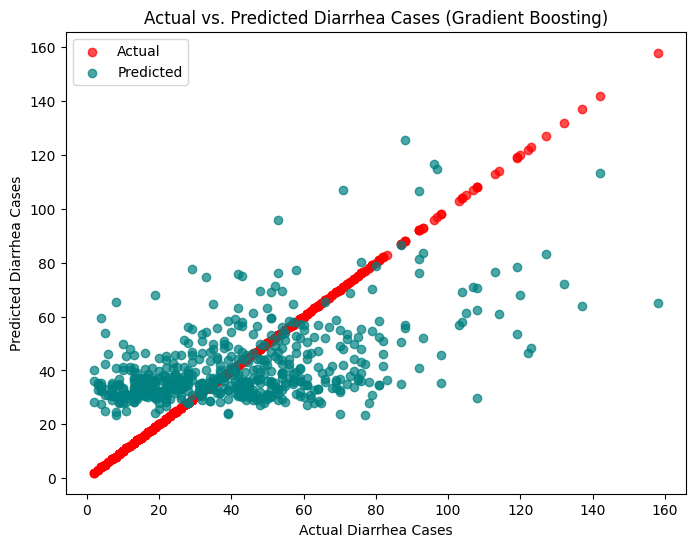

In [ ]:
rfxbt_model = GradientBoostingRegressor(random_state=42)
rfxbt_model.fit(X_train, y_train)
rfxbt_y_pred = rfxbt_model.predict(X_test)
plot_actual_vs_predicted(y_test, rfxbt_y_pred, "Gradient Boosting")

## Model Prediction with Lagged Features

### Random Forest

--- Random Forest with 0 day Lagged Features ---
Mean Squared Error: 575.8505352563644
R-squared: 0.1806756507715831


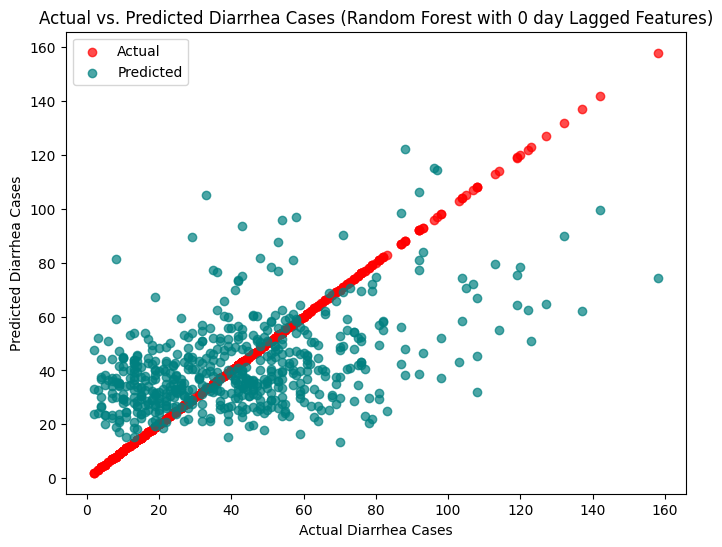

--- Random Forest with 1 day Lagged Features ---
Mean Squared Error: 679.8500630208478
R-squared: 0.2281042911801524


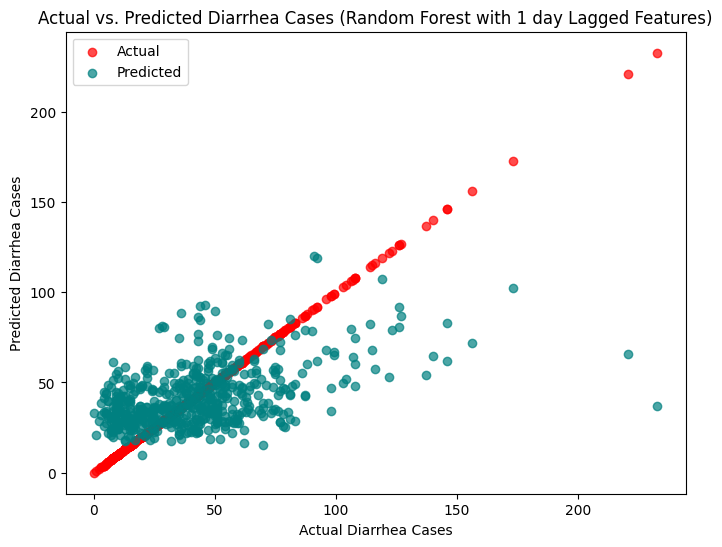

--- Random Forest with 2 day Lagged Features ---
Mean Squared Error: 714.1143197387513
R-squared: 0.21134652791972253


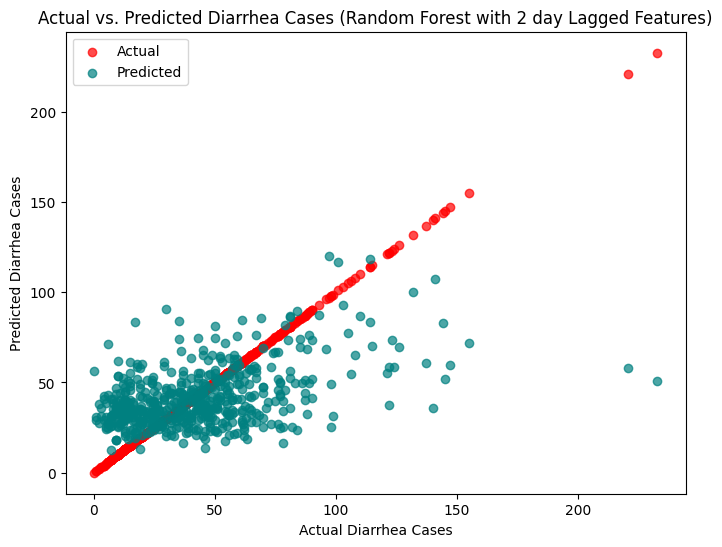

--- Random Forest with 3 day Lagged Features ---
Mean Squared Error: 681.1231585223179
R-squared: 0.24049696926786202


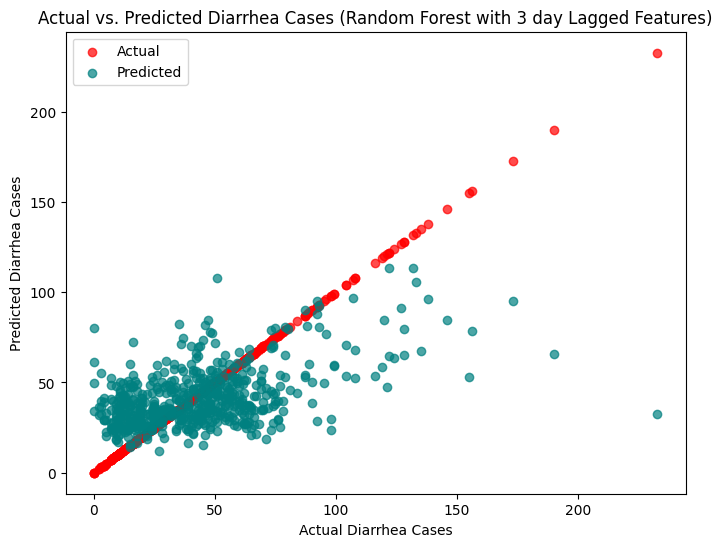

--- Random Forest with 4 day Lagged Features ---
Mean Squared Error: 573.98847196966
R-squared: 0.2309582701037266


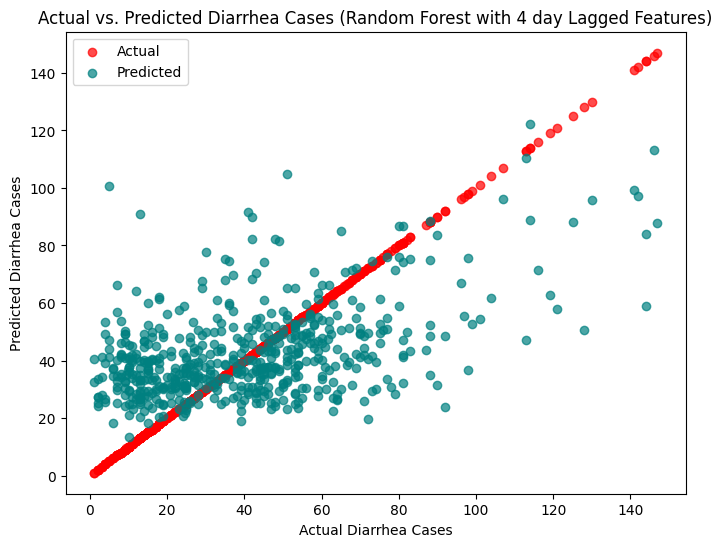

--- Random Forest with 5 day Lagged Features ---
Mean Squared Error: 593.4848106192927
R-squared: 0.20300625605654454


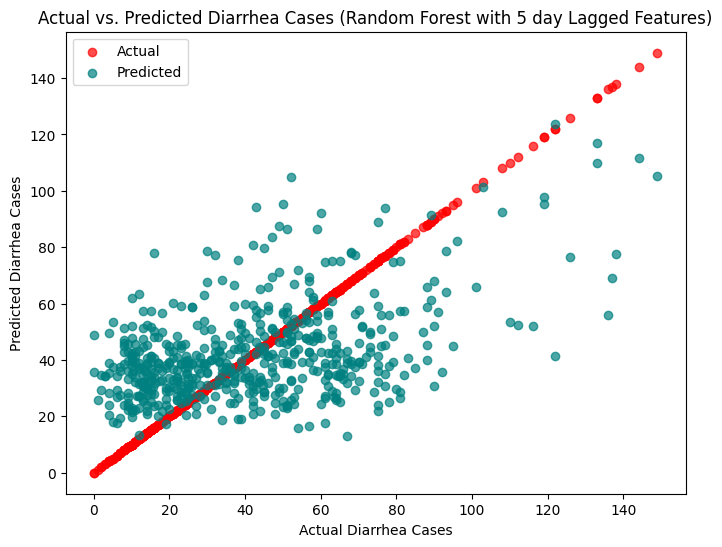

--- Random Forest with 6 day Lagged Features ---
Mean Squared Error: 710.6913927569152
R-squared: 0.1855974097486881


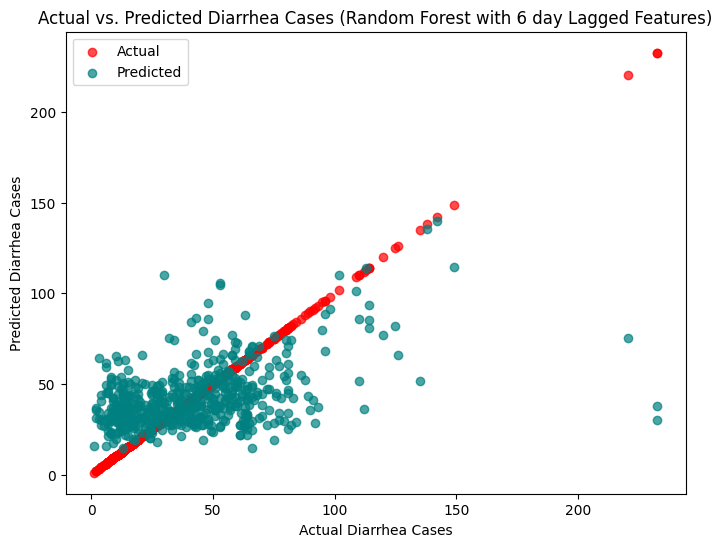

--- Random Forest with 7 day Lagged Features ---
Mean Squared Error: 610.631300168944
R-squared: 0.2265988110154048


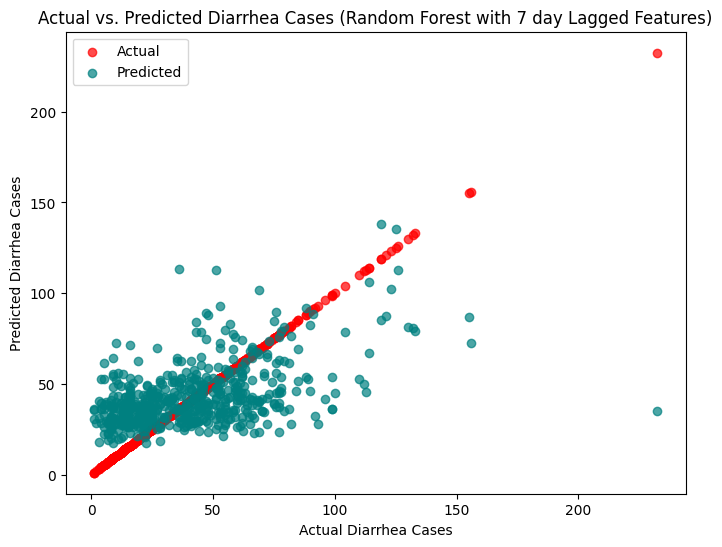

In [ ]:
i = 0
while i < 8:
  # Create lagged dataset
  X_lagged = X.shift(i)  # Shift features back by one time step
  y_current = y  # Current time step's diarrhea

  # Remove first row (which will have NaN after shifting)
  X_lagged = X_lagged.iloc[i:]
  y_current = y_current.iloc[i:]

  # Split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_current, test_size=0.2, random_state=42)

  # Train Random Forest model
  rf_model = RandomForestRegressor(random_state=42)
  rf_model.fit(X_train, y_train)

  # Make predictions
  rf_y_pred = rf_model.predict(X_test)

  # Plot actual vs predicted
  plot_actual_vs_predicted(y_test, rf_y_pred, f"Random Forest with {i} day Lagged Features")

  i+=1

### Linear Regression

--- Linear Regression with 0 day Lagged Features ---
Mean Squared Error: 595.1340353451553
R-squared: 0.15323894594320087


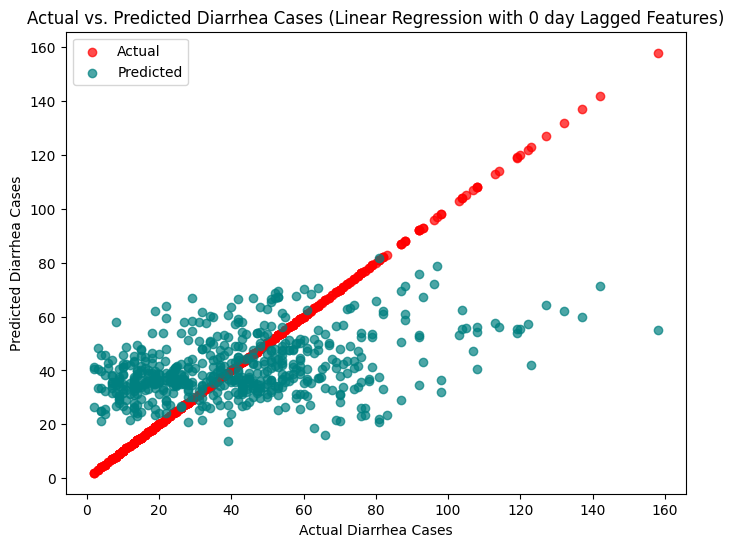

--- Linear Regression with 1 day Lagged Features ---
Mean Squared Error: 758.402764415208
R-squared: 0.13891625337503677


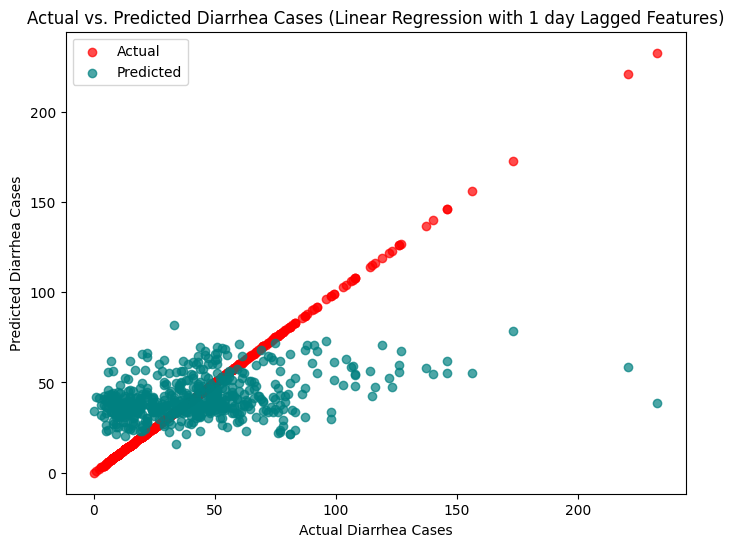

--- Linear Regression with 2 day Lagged Features ---
Mean Squared Error: 773.3426973421716
R-squared: 0.14593590058528172


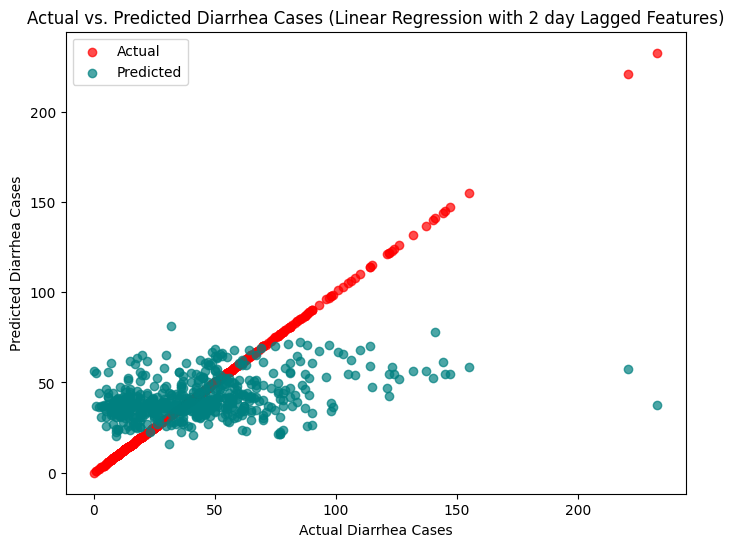

--- Linear Regression with 3 day Lagged Features ---
Mean Squared Error: 767.4557410655616
R-squared: 0.14422971235241888


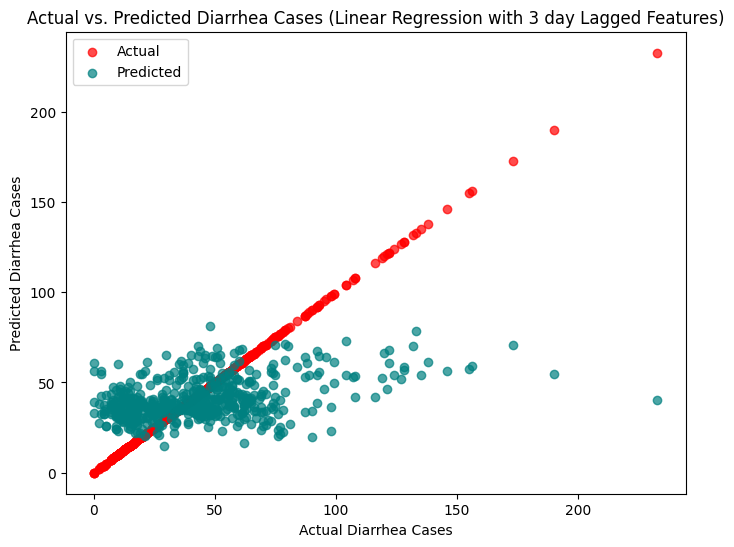

--- Linear Regression with 4 day Lagged Features ---
Mean Squared Error: 604.746358949959
R-squared: 0.18974821142412723


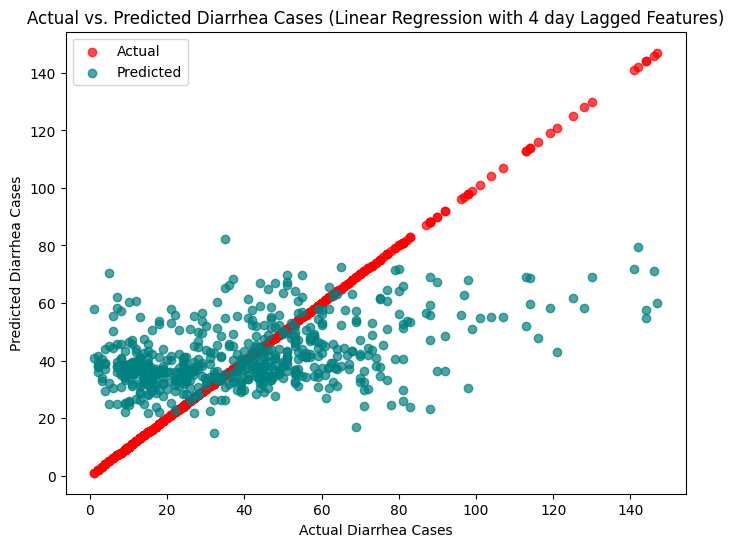

--- Linear Regression with 5 day Lagged Features ---
Mean Squared Error: 601.8566558898908
R-squared: 0.1917636628401036


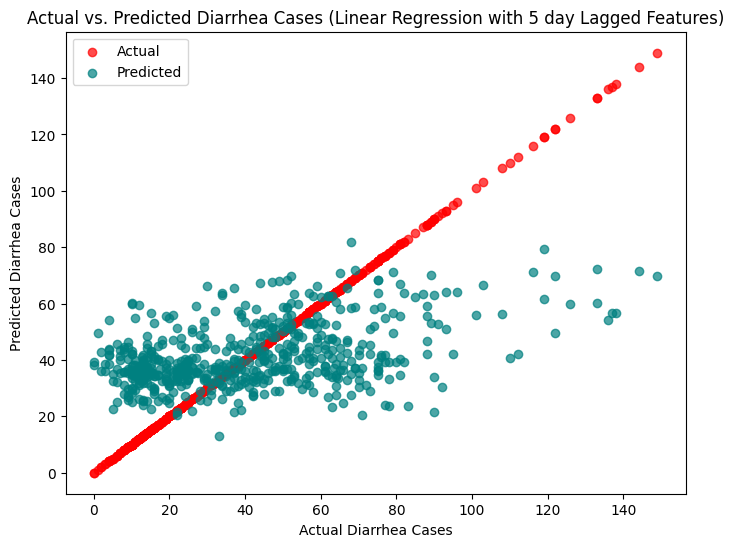

--- Linear Regression with 6 day Lagged Features ---
Mean Squared Error: 742.2854871576219
R-squared: 0.14939278903875242


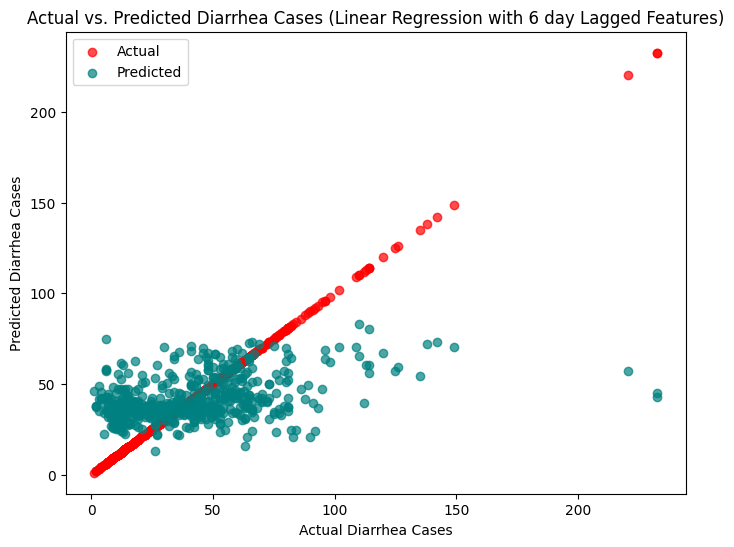

--- Linear Regression with 7 day Lagged Features ---
Mean Squared Error: 656.1500723203922
R-squared: 0.16894655425537808


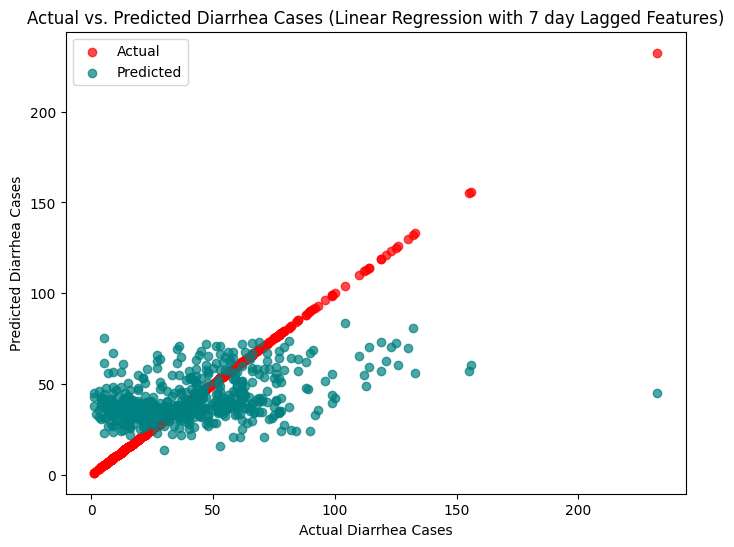

--- Linear Regression with 8 day Lagged Features ---
Mean Squared Error: 645.6655379828923
R-squared: 0.1644102561832016


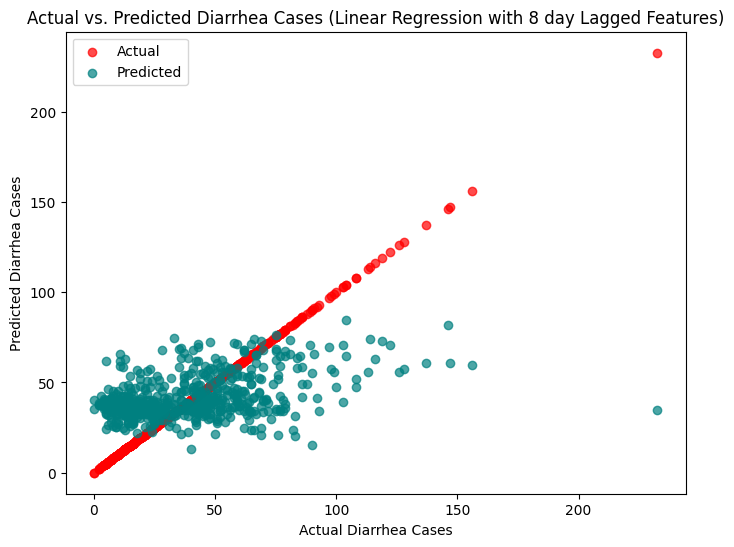

--- Linear Regression with 9 day Lagged Features ---
Mean Squared Error: 699.020341095346
R-squared: 0.13991760744664672


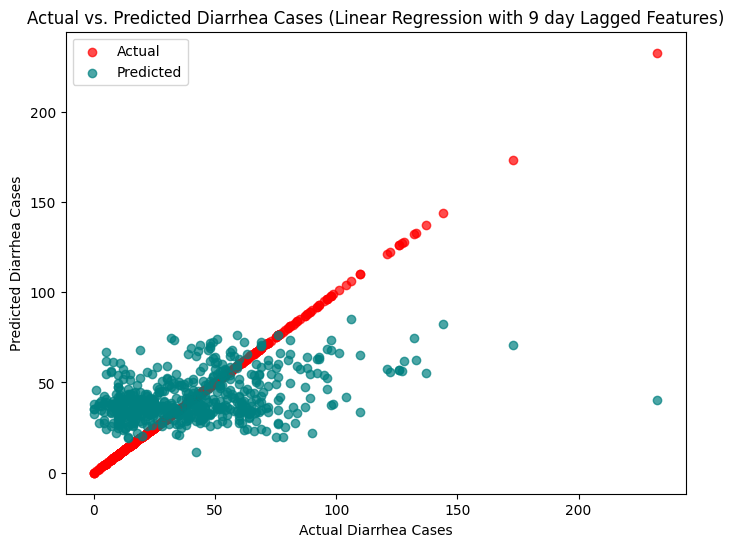

In [ ]:
i = 0
while i < 10:
  # Create lagged dataset
  X_lagged = X.shift(i)  # Shift features back by one time step
  y_current = y  # Current time step's diarrhea

  # Remove first row (which will have NaN after shifting)
  X_lagged = X_lagged.iloc[i:]
  y_current = y_current.iloc[i:]

  # Split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_current, test_size=0.2, random_state=42)

  # Train Random Forest model
  rf_model = LinearRegression()
  rf_model.fit(X_train, y_train)

  # Make predictions
  rf_y_pred = rf_model.predict(X_test)

  # Plot actual vs predicted
  plot_actual_vs_predicted(y_test, rf_y_pred, f"Linear Regression with {i} day Lagged Features")

  i+=1

### Decision Tree

--- Random Forest with 0 day Lagged Features ---
Mean Squared Error: 981.4401268844872
R-squared: -0.39640018378779507


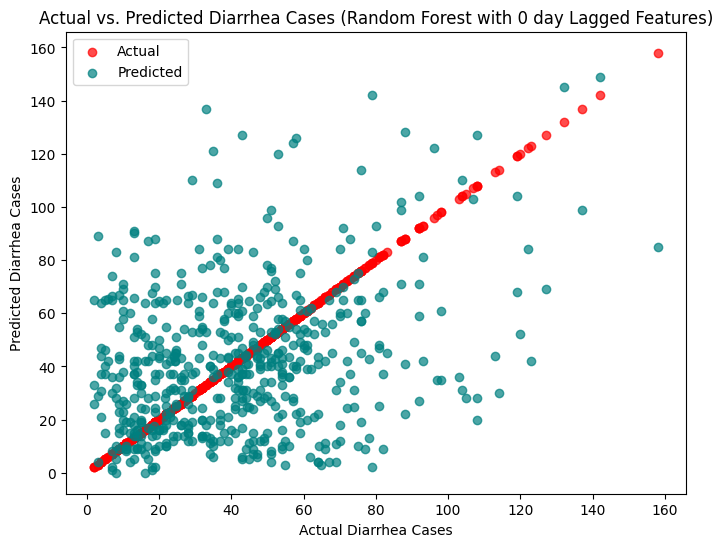

--- Random Forest with 1 day Lagged Features ---
Mean Squared Error: 1123.5806419852138
R-squared: -0.2757034576237738


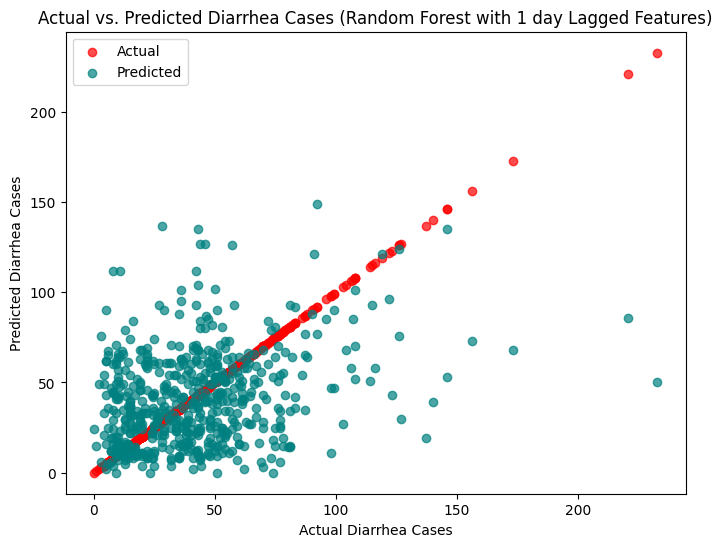

--- Random Forest with 2 day Lagged Features ---
Mean Squared Error: 1255.1981444690912
R-squared: -0.3862155503987337


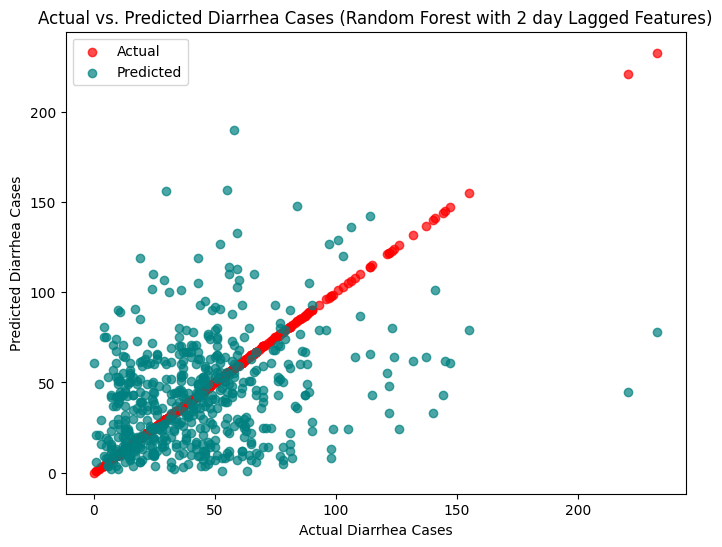

--- Random Forest with 3 day Lagged Features ---
Mean Squared Error: 1277.6580285921802
R-squared: -0.42468382232111934


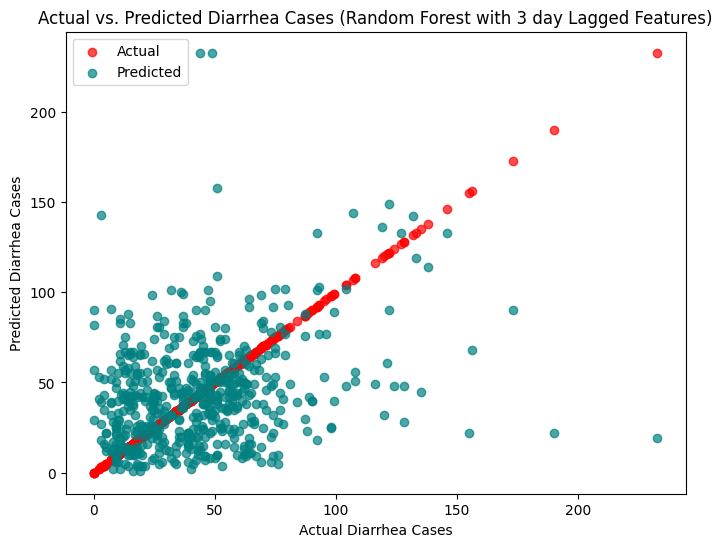

--- Random Forest with 4 day Lagged Features ---
Mean Squared Error: 1061.364633273435
R-squared: -0.42203847896525515


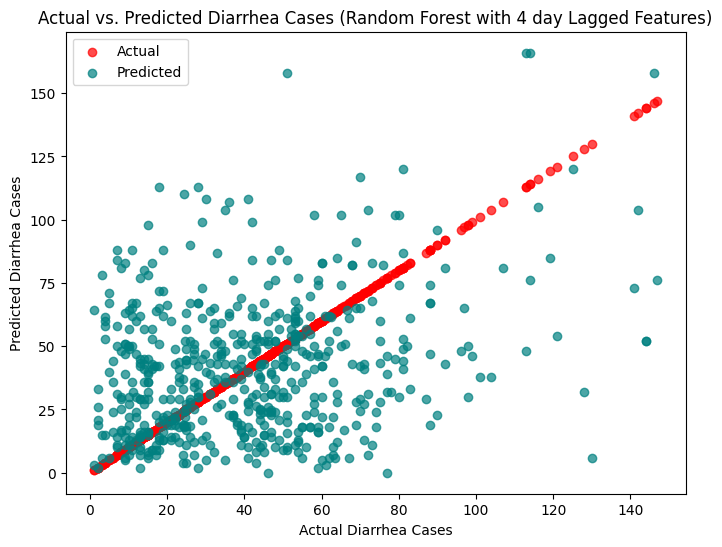

--- Random Forest with 5 day Lagged Features ---
Mean Squared Error: 1079.1471502799131
R-squared: -0.44919214810236596


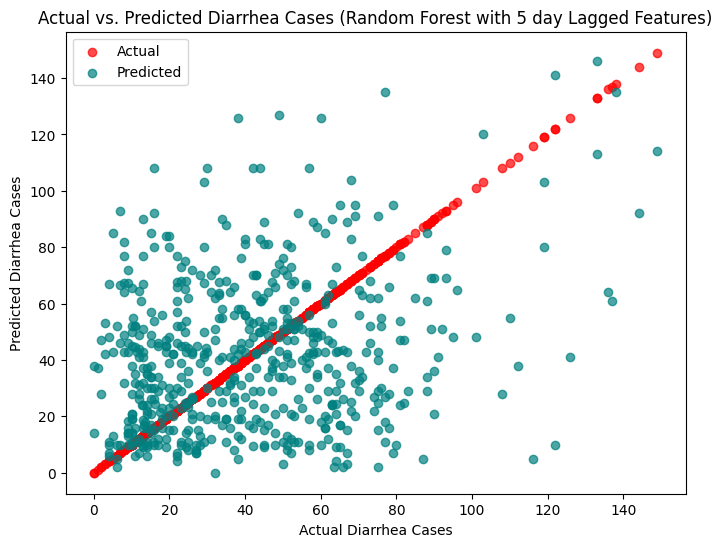

--- Random Forest with 6 day Lagged Features ---
Mean Squared Error: 1149.3256675045313
R-squared: -0.317046766286309


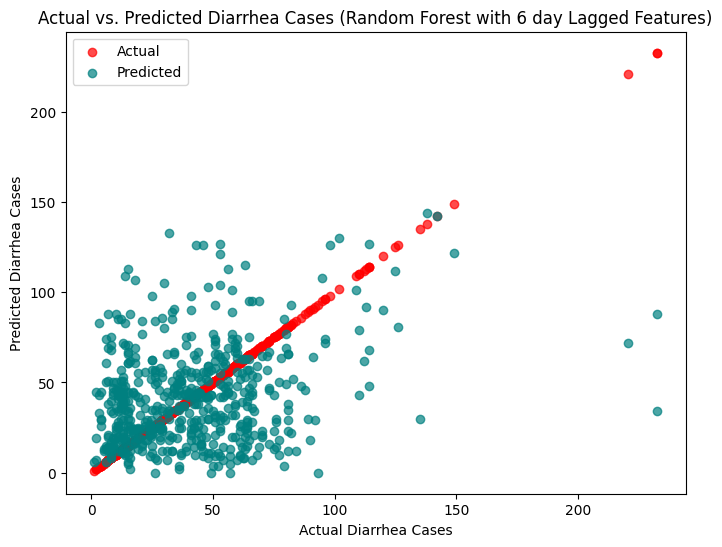

--- Random Forest with 7 day Lagged Features ---
Mean Squared Error: 1123.2231657493764
R-squared: -0.42262955018071313


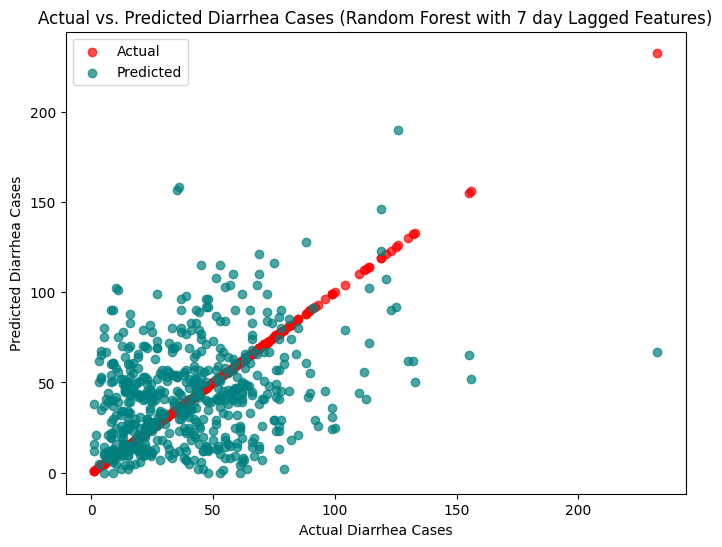

--- Random Forest with 8 day Lagged Features ---
Mean Squared Error: 1034.5584350100175
R-squared: -0.3388765031105525


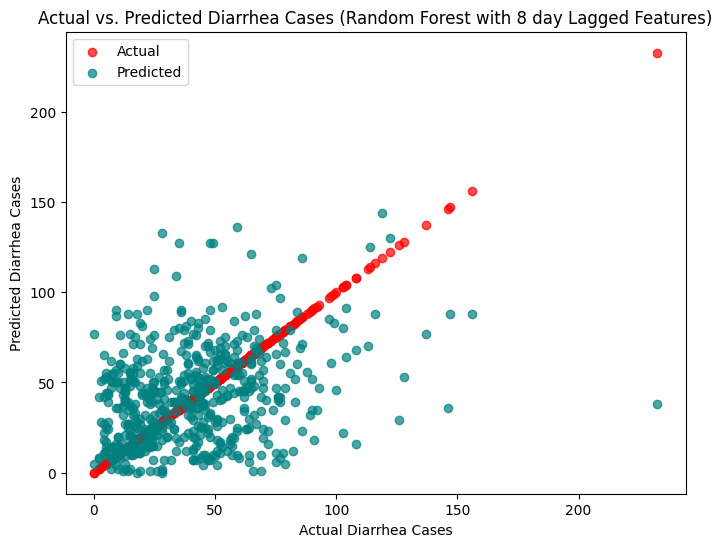

--- Random Forest with 9 day Lagged Features ---
Mean Squared Error: 1053.1096446680301
R-squared: -0.2957578049700069


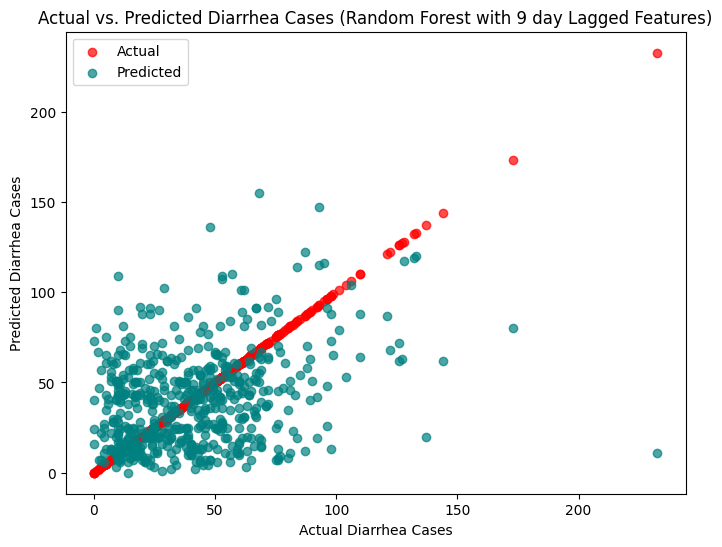

In [ ]:
### Decision Tree
i = 0
while i < 10:
  # Create lagged dataset
  X_lagged = X.shift(i)  # Shift features back by one time step
  y_current = y  # Current time step's diarrhea

  # Remove first row (which will have NaN after shifting)
  X_lagged = X_lagged.iloc[i:]
  y_current = y_current.iloc[i:]

  # Split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_current, test_size=0.2, random_state=42)

  # Train Random Forest model
  rf_model = DecisionTreeRegressor(random_state=42)
  rf_model.fit(X_train, y_train)

  # Make predictions
  rf_y_pred = rf_model.predict(X_test)

  # Plot actual vs predicted
  plot_actual_vs_predicted(y_test, rf_y_pred, f"Random Forest with {i} day Lagged Features")

  i+=1

### RFGBT

--- Gradient Boosting Regressor with 0 day Lagged Features ---
Mean Squared Error: 519.4653913779804
R-squared: 0.2609008454807289


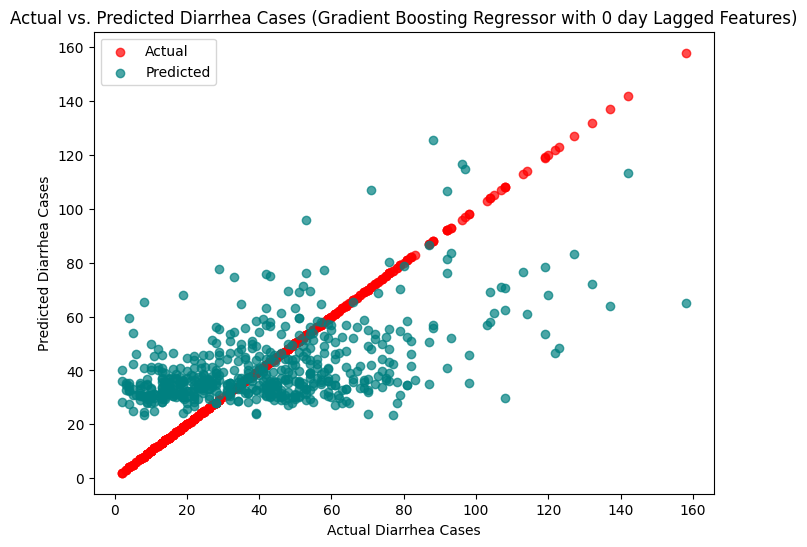

--- Gradient Boosting Regressor with 1 day Lagged Features ---
Mean Squared Error: 659.1742675508884
R-squared: 0.25157940527925793


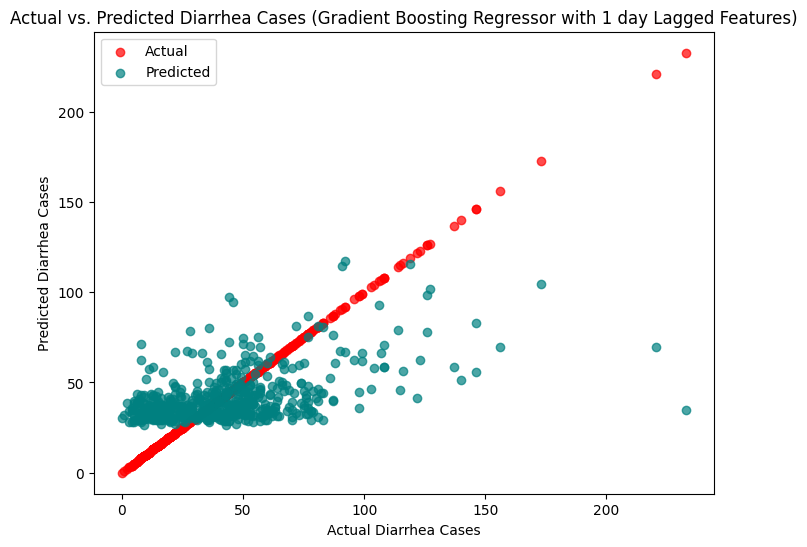

--- Gradient Boosting Regressor with 2 day Lagged Features ---
Mean Squared Error: 693.7725648987902
R-squared: 0.2338115522712999


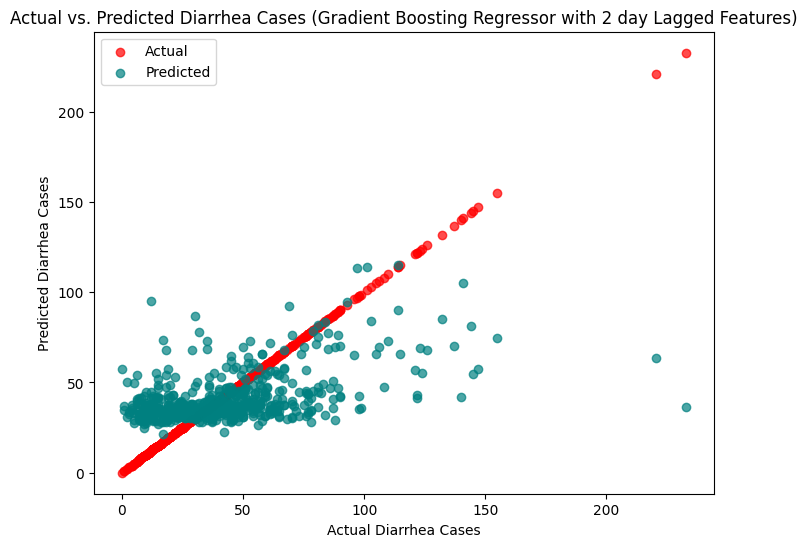

--- Gradient Boosting Regressor with 3 day Lagged Features ---
Mean Squared Error: 686.8380852189362
R-squared: 0.2341244005302049


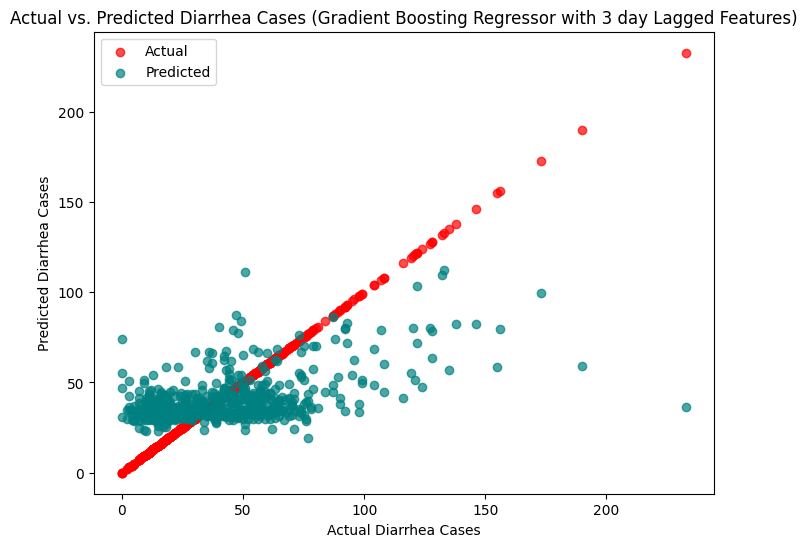

--- Gradient Boosting Regressor with 4 day Lagged Features ---
Mean Squared Error: 527.269596697482
R-squared: 0.29355319389171364


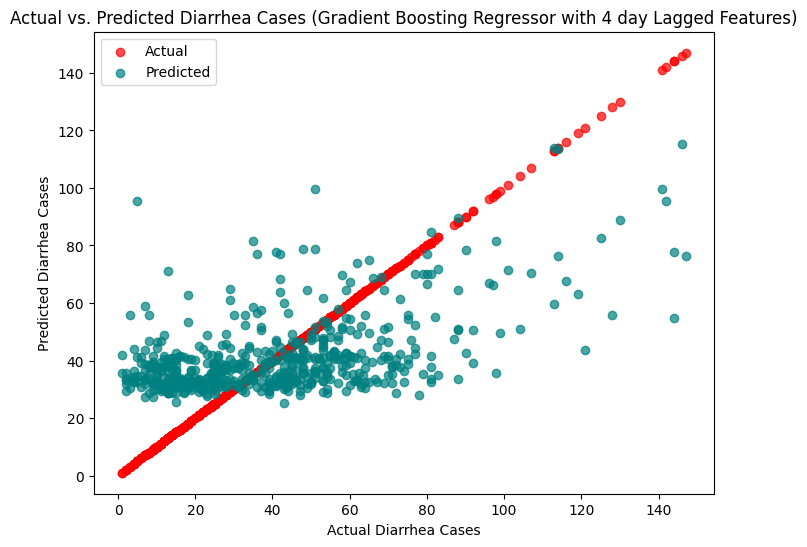

--- Gradient Boosting Regressor with 5 day Lagged Features ---
Mean Squared Error: 552.3787786530662
R-squared: 0.25820775359990433


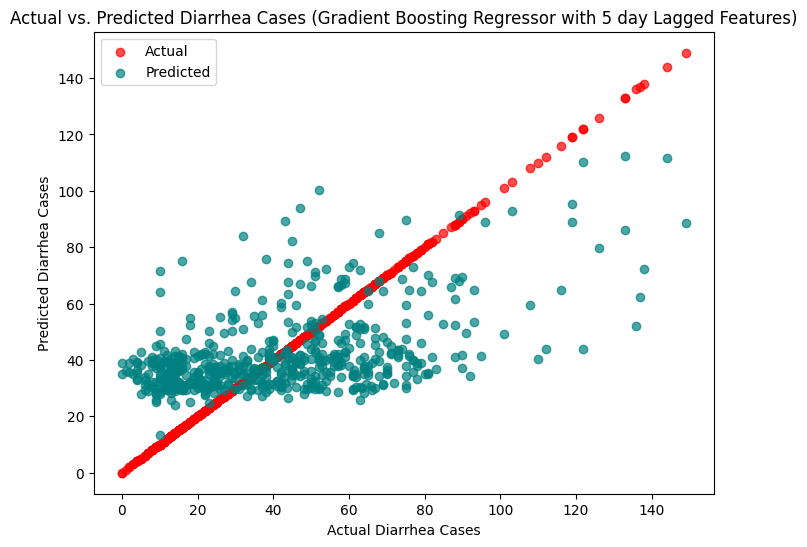

--- Gradient Boosting Regressor with 6 day Lagged Features ---
Mean Squared Error: 681.8156488155847
R-squared: 0.21868699110695955


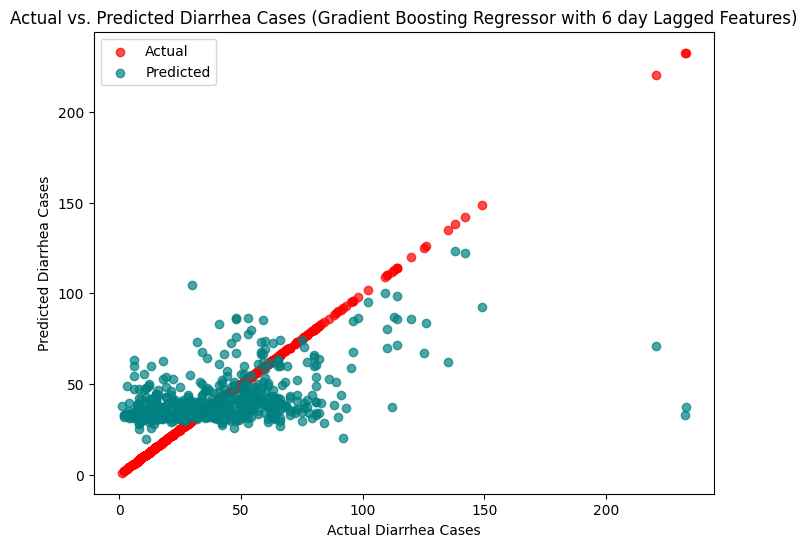

In [ ]:
i = 0
while i < 7:
  # Create lagged dataset
  X_lagged = X.shift(i)  # Shift features back by one time step
  y_current = y  # Current time step's diarrhea

  # Remove first row (which will have NaN after shifting)
  X_lagged = X_lagged.iloc[i:]
  y_current = y_current.iloc[i:]

  # Split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_current, test_size=0.2, random_state=42)

  # Train Gradient Boosting Regressor model
  gbr_model = GradientBoostingRegressor(random_state=42)
  gbr_model.fit(X_train, y_train)

  # Make predictions
  gbr_y_pred = gbr_model.predict(X_test)

  # Plot actual vs predicted
  plot_actual_vs_predicted(y_test, gbr_y_pred, f"Gradient Boosting Regressor with {i} day Lagged Features")

  i+=1

### RFXBT

--- Gradient Boosting Regressor with 0 day Lagged Features ---
Mean Squared Error: 519.4653913779804
R-squared: 0.2609008454807289


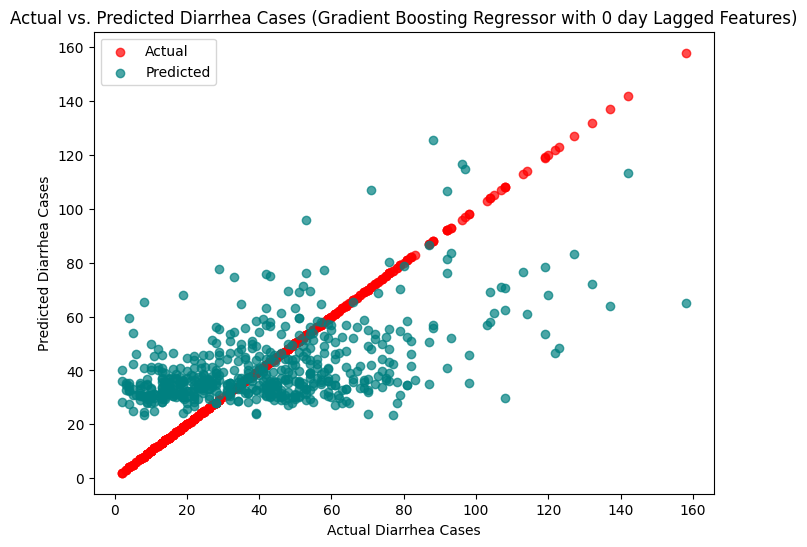

--- Gradient Boosting Regressor with 1 day Lagged Features ---
Mean Squared Error: 659.1742675508884
R-squared: 0.25157940527925793


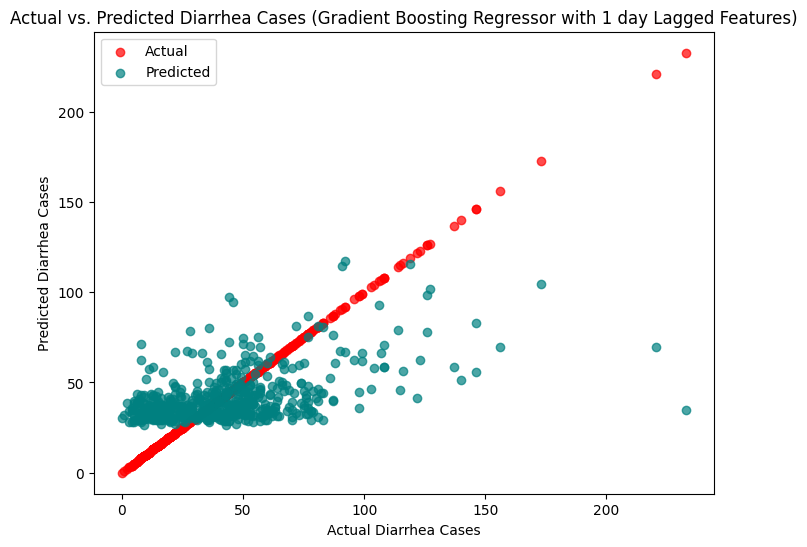

--- Gradient Boosting Regressor with 2 day Lagged Features ---
Mean Squared Error: 693.7725648987902
R-squared: 0.2338115522712999


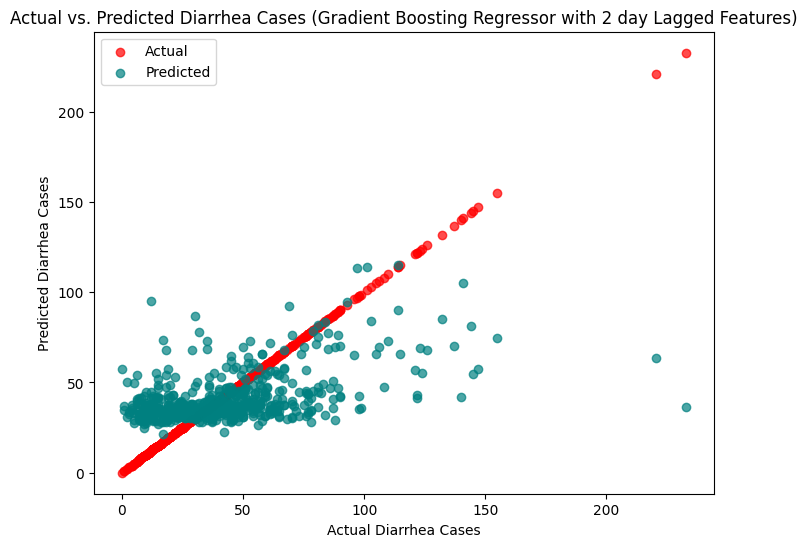

--- Gradient Boosting Regressor with 3 day Lagged Features ---
Mean Squared Error: 686.8380852189362
R-squared: 0.2341244005302049


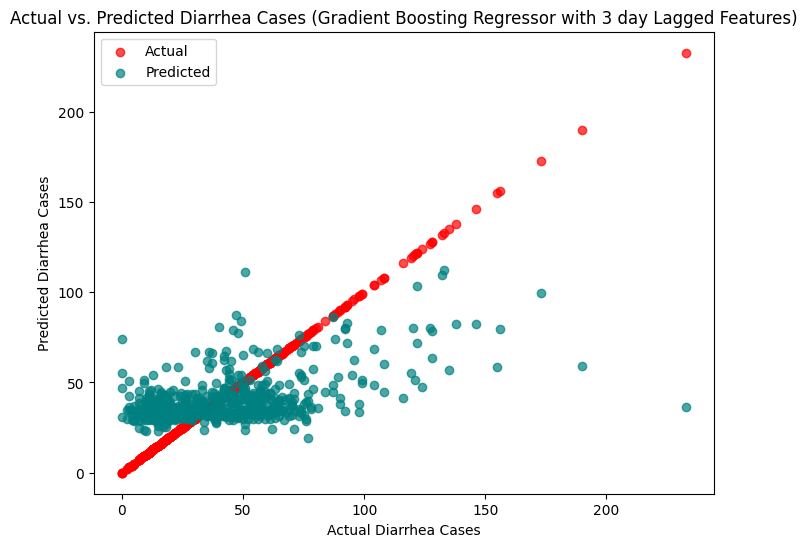

--- Gradient Boosting Regressor with 4 day Lagged Features ---
Mean Squared Error: 527.269596697482
R-squared: 0.29355319389171364


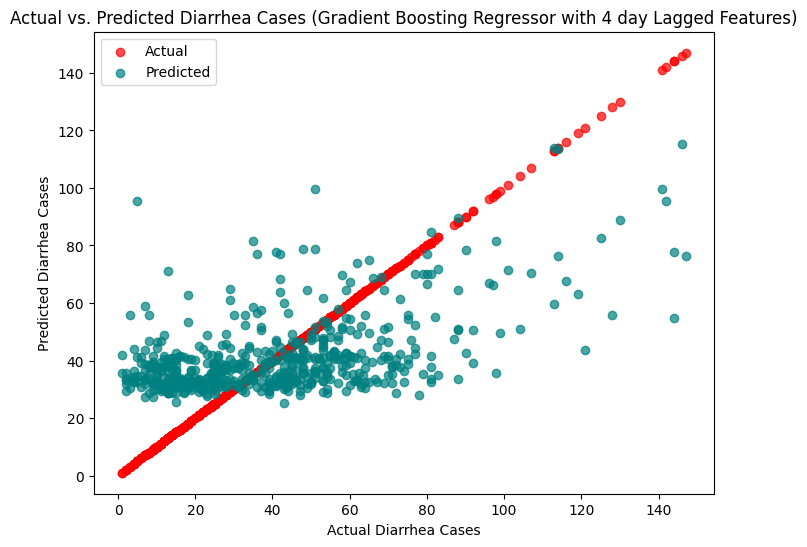

--- Gradient Boosting Regressor with 5 day Lagged Features ---
Mean Squared Error: 552.3787786530662
R-squared: 0.25820775359990433


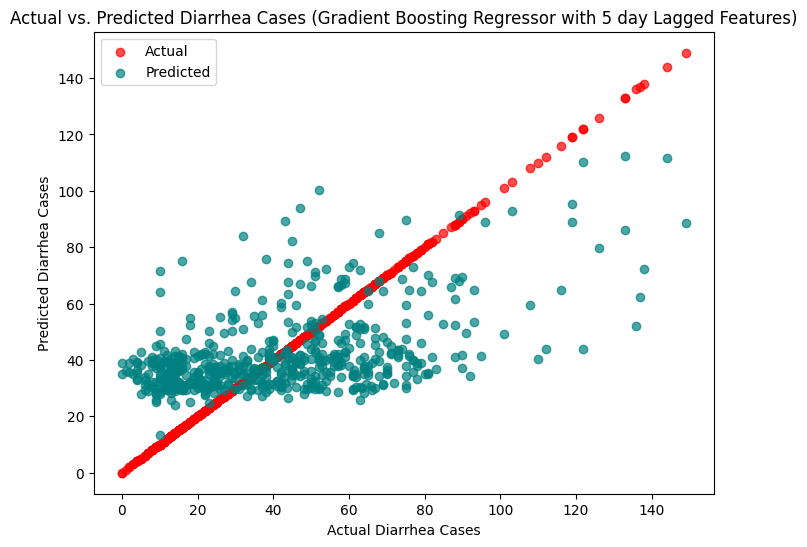

--- Gradient Boosting Regressor with 6 day Lagged Features ---
Mean Squared Error: 681.8156488155847
R-squared: 0.21868699110695955


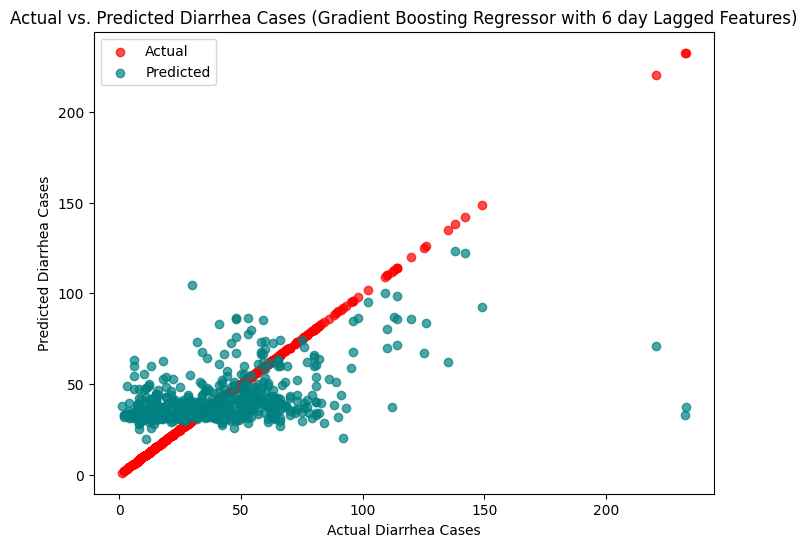

In [ ]:
i = 0
while i < 7:
  # Create lagged dataset
  X_lagged = X.shift(i)  # Shift features back by one time step
  y_current = y  # Current time step's diarrhea

  # Remove first row (which will have NaN after shifting)
  X_lagged = X_lagged.iloc[i:]
  y_current = y_current.iloc[i:]

  # Split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_current, test_size=0.2, random_state=42)

  # Train Gradient Boosting Regressor model
  gbr_model = GradientBoostingRegressor(random_state=42)
  gbr_model.fit(X_train, y_train)

  # Make predictions
  gbr_y_pred = gbr_model.predict(X_test)

  # Plot actual vs predicted
  plot_actual_vs_predicted(y_test, gbr_y_pred, f"Gradient Boosting Regressor with {i} day Lagged Features")

  i+=1